Epoch 01 | total=472.7075 | recon=460.8122 | kl=9.4018 | cls=2.4935 | acc=0.107


Epoch 02 | total=354.9725 | recon=319.6791 | kl=32.4853 | cls=2.8082 | acc=0.092


Epoch 03 | total=270.3382 | recon=245.9341 | kl=21.9084 | cls=2.4958 | acc=0.092


Epoch 04 | total=237.6571 | recon=222.2075 | kl=13.0224 | cls=2.4272 | acc=0.110


Epoch 05 | total=222.9228 | recon=208.9430 | kl=11.5996 | cls=2.3802 | acc=0.096


Epoch 06 | total=212.1866 | recon=199.1726 | kl=10.6770 | cls=2.3370 | acc=0.119


Epoch 07 | total=201.3237 | recon=186.8388 | kl=12.1851 | cls=2.2998 | acc=0.119


Epoch 08 | total=194.1860 | recon=178.0078 | kl=13.8751 | cls=2.3030 | acc=0.128


Epoch 09 | total=187.8702 | recon=171.7651 | kl=13.8612 | cls=2.2440 | acc=0.146


Epoch 10 | total=181.0827 | recon=164.1028 | kl=14.8081 | cls=2.1719 | acc=0.176


Epoch 11 | total=174.1508 | recon=155.3851 | kl=16.6683 | cls=2.0974 | acc=0.228


Epoch 12 | total=169.1808 | recon=150.0038 | kl=17.1563 | cls=2.0206 | acc=0.305


Epoch 13 | total=164.1281 | recon=144.1557 | kl=18.0088 | cls=1.9635 | acc=0.330


Epoch 14 | total=159.6378 | recon=139.2334 | kl=18.4935 | cls=1.9109 | acc=0.357


Epoch 15 | total=155.7573 | recon=134.2697 | kl=19.6468 | cls=1.8409 | acc=0.397


Epoch 16 | total=152.7843 | recon=130.7458 | kl=20.2657 | cls=1.7728 | acc=0.458


Epoch 17 | total=149.5307 | recon=127.4752 | kl=20.3157 | cls=1.7398 | acc=0.479


Epoch 18 | total=146.5301 | recon=123.6791 | kl=21.1418 | cls=1.7092 | acc=0.488


Epoch 19 | total=144.4205 | recon=121.4012 | kl=21.3663 | cls=1.6530 | acc=0.530


Epoch 20 | total=142.2319 | recon=118.8041 | kl=21.8142 | cls=1.6136 | acc=0.570


Epoch 21 | total=140.3152 | recon=117.1200 | kl=21.6051 | cls=1.5901 | acc=0.568


Epoch 22 | total=137.7500 | recon=113.9587 | kl=22.2429 | cls=1.5483 | acc=0.582


Epoch 23 | total=135.8065 | recon=111.4183 | kl=22.8715 | cls=1.5167 | acc=0.607


Epoch 24 | total=134.1871 | recon=109.4428 | kl=23.2647 | cls=1.4796 | acc=0.611


Epoch 25 | total=132.0872 | recon=107.3725 | kl=23.2520 | cls=1.4627 | acc=0.606


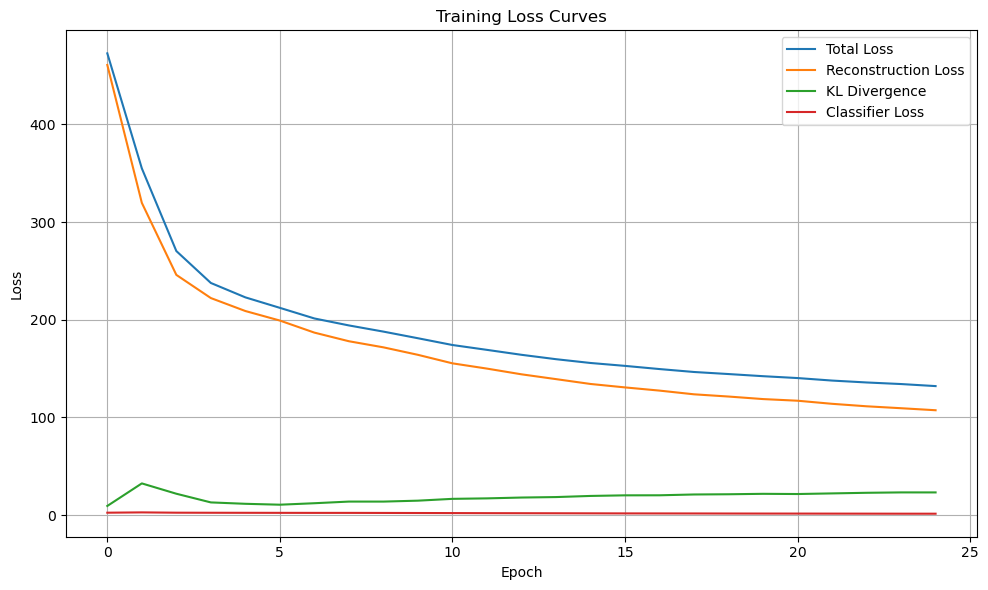

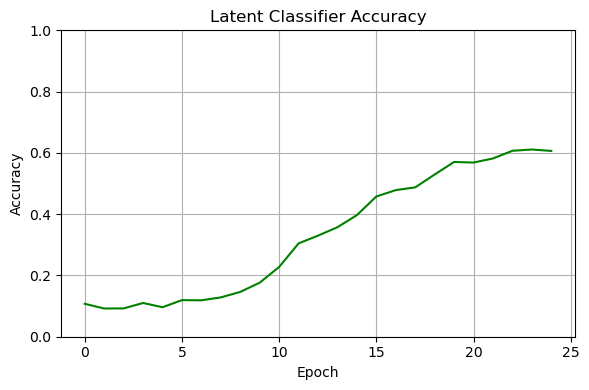

In [ ]:
# === ConvVAE with Latent Classifier (MNIST) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 1. Load Subset of MNIST =====
transform = transforms.Compose([transforms.ToTensor()])
mnist_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
subset_indices = list(range(1000))  # Train on only 10,000 samples
mnist = Subset(mnist_full, subset_indices)
loader = DataLoader(mnist, batch_size=128, shuffle=True)

# ===== 2. ConvVAE with classifier in latent space =====
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20, n_classes=10):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

        # Classifier in latent space
        self.classifier = nn.Linear(latent_dim, n_classes)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits, z

# ===== 3. Loss Function =====
def loss_fn(x, recon, mu, logvar, logits, y, cls_weight=1.0):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum') / x.size(0)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    cls_loss = F.cross_entropy(logits, y)
    total_loss = recon_loss + kl_div + cls_weight * cls_loss
    return total_loss, recon_loss, kl_div, cls_loss

# ===== 4. Training =====
model = ConvVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 25
train_losses, recon_losses, kl_losses, cls_losses, acc_list = [], [], [], [], []

for epoch in range(n_epochs):
    total_loss, total_recon, total_kl, total_cls, total_acc = 0, 0, 0, 0, 0
    num_batches = 0
    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, logits, _ = model(x)
        loss, r, k, c = loss_fn(x, recon, mu, logvar, logits, y)
        loss.backward()
        optimizer.step()

        pred_labels = torch.argmax(logits, dim=1)
        acc = (pred_labels == y).float().mean().item()

        total_loss += loss.item()
        total_recon += r.item()
        total_kl += k.item()
        total_cls += c.item()
        total_acc += acc
        num_batches += 1

        loop.set_postfix(loss=loss.item(), acc=acc)

    avg_loss = total_loss / num_batches
    avg_recon = total_recon / num_batches
    avg_kl = total_kl / num_batches
    avg_cls = total_cls / num_batches
    avg_acc = total_acc / num_batches

    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    cls_losses.append(avg_cls)
    acc_list.append(avg_acc)

    print(f"Epoch {epoch+1:02d} | total={avg_loss:.4f} | recon={avg_recon:.4f} | kl={avg_kl:.4f} | cls={avg_cls:.4f} | acc={avg_acc:.3f}")

# ===== 5. Loss Curves =====
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(kl_losses, label="KL Divergence")
plt.plot(cls_losses, label="Classifier Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curves.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(acc_list, label="Classifier Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Latent Classifier Accuracy")
plt.ylim(0, 1.0)
plt.grid(True)
plt.tight_layout()
plt.savefig("classifier_accuracy.png", dpi=300)
plt.show()

# ===== 6. Visualize latent space with t-SNE =====
model.eval()
all_z, all_y = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        _, _, _, _, z = model(x)
        all_z.append(z.cpu())
        all_y.append(y)
all_z = torch.cat(all_z).numpy()
all_y = torch.cat(all_y).numpy()

z_tsne = TSNE(n_components=2, perplexity=30, init="pca").fit_transform(all_z)

plt.figure(figsize=(7, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=all_y, cmap="tab10", s=5)
plt.colorbar()
plt.title("t-SNE of Latent Space (colored by digit)")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.tight_layout()
plt.savefig("latent_tsne.png", dpi=300)
plt.show()

# ===== 7. Sample from each cluster =====
def sample_from_clusters(model, z_vals, labels, n_per_class=5):
    fig, axs = plt.subplots(1, 10, figsize=(12, 2))
    for digit in range(10):
        idxs = (labels == digit)
        if np.sum(idxs) == 0:
            continue
        cluster_z = z_vals[idxs]
        center = cluster_z.mean(axis=0)
        center_tensor = torch.tensor(center, device=device).repeat(n_per_class, 1)
        with torch.no_grad():
            samples = model.decode(center_tensor).detach().cpu()
        for i in range(n_per_class):
            axs[digit].imshow(samples[i, 0], cmap="gray")
            axs[digit].axis('off')
    plt.suptitle("Samples from cluster centers (z-space)")
    plt.tight_layout()
    plt.savefig("cluster_samples.png", dpi=300)
    plt.show()

sample_from_clusters(model, all_z, all_y)


Epoch 1/25: 100%|███████████████████████████████| 40/40 [00:01<00:00, 21.94it/s]


Epoch 01 | total=4.3756 | recon=0.4944 | kl=0.4609 | cls=1.7101 | acc=0.442


Epoch 2/25: 100%|███████████████████████████████| 40/40 [00:02<00:00, 15.25it/s]


Epoch 02 | total=3.3088 | recon=0.2864 | kl=0.8039 | cls=1.1092 | acc=0.725


Epoch 3/25: 100%|███████████████████████████████| 40/40 [00:03<00:00, 13.22it/s]


Epoch 03 | total=2.8537 | recon=0.2368 | kl=0.8953 | cls=0.8608 | acc=0.835


Epoch 4/25: 100%|███████████████████████████████| 40/40 [00:02<00:00, 19.67it/s]


Epoch 04 | total=2.5277 | recon=0.2258 | kl=0.9232 | cls=0.6894 | acc=0.886


Epoch 5/25: 100%|███████████████████████████████| 40/40 [00:01<00:00, 22.52it/s]


Epoch 05 | total=2.3015 | recon=0.2224 | kl=0.9080 | cls=0.5856 | acc=0.912


Epoch 6/25: 100%|███████████████████████████████| 40/40 [00:01<00:00, 22.12it/s]


Epoch 06 | total=2.1442 | recon=0.2185 | kl=0.9023 | cls=0.5117 | acc=0.923


Epoch 7/25: 100%|███████████████████████████████| 40/40 [00:01<00:00, 22.09it/s]


Epoch 07 | total=1.9903 | recon=0.2194 | kl=0.8725 | cls=0.4492 | acc=0.940


Epoch 8/25: 100%|███████████████████████████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 08 | total=1.8804 | recon=0.2183 | kl=0.8439 | cls=0.4091 | acc=0.943


Epoch 9/25: 100%|███████████████████████████████| 40/40 [00:02<00:00, 18.30it/s]


Epoch 09 | total=1.8123 | recon=0.2200 | kl=0.8287 | cls=0.3818 | acc=0.943


Epoch 10/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 20.64it/s]


Epoch 10 | total=1.7427 | recon=0.2197 | kl=0.8209 | cls=0.3511 | acc=0.950


Epoch 11/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 21.95it/s]


Epoch 11 | total=1.6890 | recon=0.2195 | kl=0.8094 | cls=0.3300 | acc=0.954


Epoch 12/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 20.94it/s]


Epoch 12 | total=1.6346 | recon=0.2200 | kl=0.7864 | cls=0.3141 | acc=0.951


Epoch 13/25: 100%|██████████████████████████████| 40/40 [00:02<00:00, 14.41it/s]


Epoch 13 | total=1.5908 | recon=0.2186 | kl=0.8049 | cls=0.2836 | acc=0.961


Epoch 14/25: 100%|██████████████████████████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 14 | total=1.5233 | recon=0.2202 | kl=0.7765 | cls=0.2633 | acc=0.969


Epoch 15/25: 100%|██████████████████████████████| 40/40 [00:02<00:00, 18.48it/s]


Epoch 15 | total=1.4696 | recon=0.2184 | kl=0.7516 | cls=0.2498 | acc=0.967


Epoch 16/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 22.19it/s]


Epoch 16 | total=1.4364 | recon=0.2185 | kl=0.7436 | cls=0.2371 | acc=0.970


Epoch 17/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 22.21it/s]


Epoch 17 | total=1.4197 | recon=0.2191 | kl=0.7421 | cls=0.2292 | acc=0.969


Epoch 18/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 21.78it/s]


Epoch 18 | total=1.3715 | recon=0.2198 | kl=0.7240 | cls=0.2139 | acc=0.976


Epoch 19/25: 100%|██████████████████████████████| 40/40 [00:03<00:00, 10.70it/s]


Epoch 19 | total=1.3441 | recon=0.2210 | kl=0.7171 | cls=0.2030 | acc=0.974


Epoch 20/25: 100%|██████████████████████████████| 40/40 [00:02<00:00, 16.12it/s]


Epoch 20 | total=1.3108 | recon=0.2201 | kl=0.7046 | cls=0.1931 | acc=0.978


Epoch 21/25: 100%|██████████████████████████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 21 | total=1.2965 | recon=0.2203 | kl=0.7054 | cls=0.1854 | acc=0.978


Epoch 22/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 22.20it/s]


Epoch 22 | total=1.2759 | recon=0.2209 | kl=0.6927 | cls=0.1812 | acc=0.977


Epoch 23/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 22.18it/s]


Epoch 23 | total=1.2716 | recon=0.2194 | kl=0.6902 | cls=0.1810 | acc=0.976


Epoch 24/25: 100%|██████████████████████████████| 40/40 [00:02<00:00, 18.66it/s]


Epoch 24 | total=1.2569 | recon=0.2202 | kl=0.6817 | cls=0.1775 | acc=0.975


Epoch 25/25: 100%|██████████████████████████████| 40/40 [00:01<00:00, 21.11it/s]


Epoch 25 | total=1.2469 | recon=0.2202 | kl=0.6968 | cls=0.1650 | acc=0.979


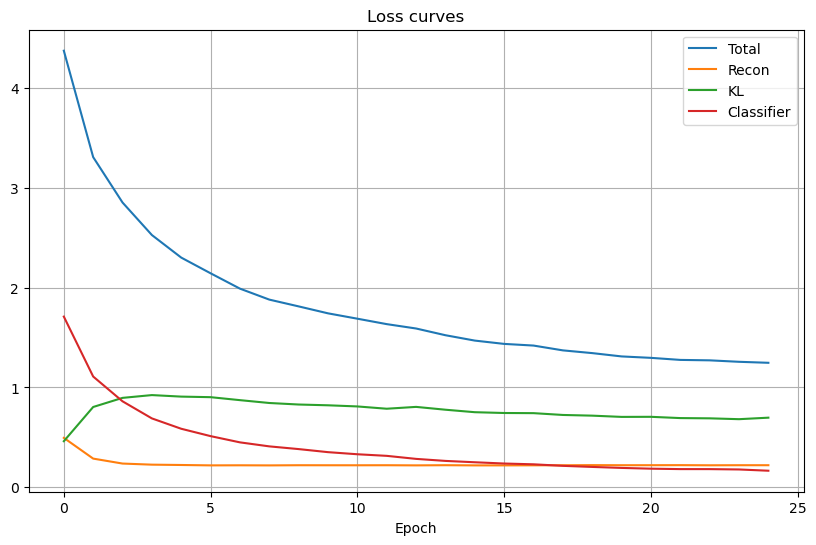

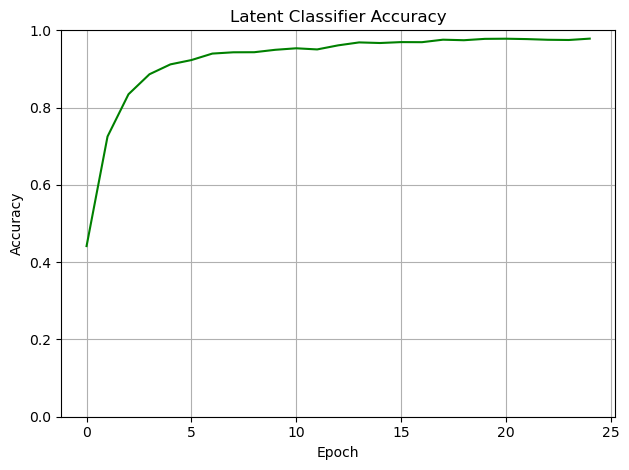

In [ ]:
# === ConvVAE with Latent Classifier (MNIST, Optimized) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 1. Load Subset of MNIST and Normalize =====
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
subset_indices = list(range(5000))  # Fewer samples to reduce memory load
mnist = Subset(mnist_full, subset_indices)
loader = DataLoader(mnist, batch_size=128, shuffle=True)

# ===== 2. ConvVAE with classifier in latent space =====
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

        self.classifier = nn.Linear(latent_dim, n_classes)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z):
        return self.decoder(self.decoder_input(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, self.classifier(z), z

# ===== 3. Loss Function =====
def loss_fn(x, recon, mu, logvar, logits, y, cls_weight=2.0):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    cls_loss = F.cross_entropy(logits, y)
    total = recon_loss + kl_div + cls_weight * cls_loss
    return total, recon_loss, kl_div, cls_loss

# ===== 4. Training =====
model = ConvVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 25

total_hist, recon_hist, kl_hist, cls_hist, acc_hist = [], [], [], [], []

for epoch in range(n_epochs):
    total_loss = recon_loss = kl_loss = cls_loss = acc_total = 0
    for x, y in tqdm(loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, logits, _ = model(x)
        loss, r, k, c = loss_fn(x, recon, mu, logvar, logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        recon_loss += r.item()
        kl_loss += k.item()
        cls_loss += c.item()
        acc_total += (logits.argmax(1) == y).float().mean().item()

    N = len(loader)
    total_hist.append(total_loss / N)
    recon_hist.append(recon_loss / N)
    kl_hist.append(kl_loss / N)
    cls_hist.append(cls_loss / N)
    acc_hist.append(acc_total / N)

    print(f"Epoch {epoch+1:02d} | total={total_hist[-1]:.4f} | recon={recon_hist[-1]:.4f} | kl={kl_hist[-1]:.4f} | cls={cls_hist[-1]:.4f} | acc={acc_hist[-1]:.3f}")

# ===== 5. Plot Curves =====
plt.figure(figsize=(10, 6))
plt.plot(total_hist, label="Total")
plt.plot(recon_hist, label="Recon")
plt.plot(kl_hist, label="KL")
plt.plot(cls_hist, label="Classifier")
plt.legend(); plt.grid(); plt.title("Loss curves"); plt.xlabel("Epoch")
plt.savefig("loss_curves.png"); plt.show()

plt.plot(acc_hist, color='green')
plt.title("Latent Classifier Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.ylim(0, 1.0)
plt.grid(); plt.tight_layout()
plt.savefig("classifier_accuracy.png")
plt.show()

# ===== 6. Visualize latent space with t-SNE (subset only) =====
model.eval(); z_all, y_all = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        _, _, _, _, z = model(x)
        z_all.append(z.cpu())
        y_all.append(y)
z_all = torch.cat(z_all).numpy().astype(np.float32)
y_all = torch.cat(y_all).numpy()

z_tsne = TSNE(n_components=2, perplexity=30, init="pca").fit_transform(z_all[:3000])

plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_all[:3000], cmap="tab10", s=5)
plt.title("t-SNE of Latent Space"); plt.colorbar()
plt.tight_layout(); plt.savefig("latent_tsne.png"); plt.show()

# ===== 7. Cluster-based Sampling (1 sample/class) =====
def sample_from_clusters(model, z_vals, labels):
    fig, axs = plt.subplots(1, 10, figsize=(12, 2))
    for d in range(10):
        idxs = labels == d
        if not np.any(idxs): continue
        center = z_vals[idxs].mean(axis=0)
        z_tensor = torch.tensor(center, device=device).unsqueeze(0)
        sample = model.decode(z_tensor).detach().cpu()[0, 0]
        axs[d].imshow(sample, cmap="gray")
        axs[d].axis("off")
    plt.suptitle("Samples from Latent Cluster Centers")
    plt.tight_layout(); plt.savefig("cluster_samples.png"); plt.show()

sample_from_clusters(model, z_all, y_all)


In [42]:
# === ConvVAE with Latent Classifier (MNIST, 2D) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 1. Load Light MNIST Subset =====
transform = transforms.Compose([transforms.ToTensor()])
mnist_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
subset_indices = list(range(60000))
mnist = Subset(mnist_full, subset_indices)
loader = DataLoader(mnist, batch_size=2000, shuffle=True)

# ===== 2. ConvVAE Definition (2D latent) =====
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20, n_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        # self.decoder = nn.Sequential(
        #     nn.Unflatten(1, (64, 7, 7)),
        #     nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
        #     nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        # )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 14×14
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 28×28
            nn.Conv2d(32, 1, kernel_size=3, padding=1), nn.Sigmoid()
        )

        self.classifier = nn.Linear(latent_dim, n_classes)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits, z

# ===== 3. Loss Function =====
def loss_fn(x, recon, mu, logvar, logits, y):
    recon_loss = F.binary_cross_entropy(recon, x,  reduction='mean') 
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    cls_loss = F.cross_entropy(logits, y)
    return recon_loss + kl + 1000*cls_loss, recon_loss, kl, cls_loss

# ===== 4. Train Model and Save Latents =====
model = ConvVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

zs, ys = [], []
train_losses, recon_losses, kl_losses, cls_losses, accuracies = [], [], [], [], []

model.train()
for epoch in range(10):
    total_loss = total_recon = total_kl = total_cls = correct = total_samples = 0
    loop = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, logits, z = model(x)
        loss, recon_loss, kl_loss, cls_loss = loss_fn(x, recon, mu, logvar, logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
        total_cls += cls_loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_samples += y.size(0)

    avg_loss = total_loss / len(loader)
    avg_recon = total_recon / len(loader)
    avg_kl = total_kl / len(loader)
    avg_cls = total_cls / len(loader)
    accuracy = correct / total_samples

    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    cls_losses.append(avg_cls)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1:02d} | Total: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | Cls: {avg_cls:.4f} | Acc: {accuracy:.4f}")

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, _, _, _, z = model(x)
            zs.append(z.cpu())
            ys.append(y)
    model.train()

# ===== Plot Training Curves =====
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(kl_losses, label="KL Divergence")
plt.plot(cls_losses, label="Classifier Loss")
plt.plot(accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.title("VAE Training Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vae_training_metrics.png", dpi=300)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(accuracies, label="Accuracy")
plt.show()


# ===== Save z and y =====
z_all = torch.cat(zs).numpy()
y_all = torch.cat(ys).numpy()
np.savez("latent_embeddings.npz", z=z_all, y=y_all)
print("Saved latent z and labels y to latent_embeddings.npz")



# === Load Latents and Apply 2D PCA ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load latent variables and labels
data = np.load("latent_embeddings.npz")
z = data["z"]
y = data["y"]

# Apply PCA (just to demonstrate; z is already 2D from VAE)
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)

# Plot
plt.figure(figsize=(7, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap="tab10", s=10)
plt.colorbar(scatter, ticks=range(10), label="Digit Label")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA of VAE Latent Space")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_latent_plot.png", dpi=300)
plt.show()



Epoch 01 | Total: 1447.7224 | Recon: 0.4280 | KL: 62.1439 | Cls: 1.3852 | Acc: 0.5874


KeyboardInterrupt: 

In [97]:
# === ConvVAE with Latent Classifier (MNIST, 2D) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ===== 1. Load Light MNIST Subset Vanilla  =====
# transform = transforms.Compose([transforms.ToTensor()])
# mnist_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
# subset_indices = list(range(10000))
# mnist = Subset(mnist_full, subset_indices)
# loader = DataLoader(mnist, batch_size=200, shuffle=True)


# ===== 1. Load MNIST Dataset with Augmentation =====
augment = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([transforms.ToTensor()])

mnist_full = datasets.MNIST(root="./data", train=True, download=True, transform=augment)
val_size = 6000
train_size = len(mnist_full) - val_size
train_data, val_data = random_split(mnist_full, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# ===== 2. ConvVAE Definition (2D latent) =====
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

        self.classifier = nn.Linear(latent_dim, n_classes)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits, z

# ===== 3. Loss Function =====
def loss_fn(x, recon, mu, logvar, logits, y):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='mean')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    cls_loss = F.cross_entropy(logits, y)
    return 1000*recon_loss + kl + 200*cls_loss, recon_loss, kl, cls_loss

# ===== 4. Train Model and Save Latents =====
model = ConvVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

zs, ys = [], []
train_losses, recon_losses, kl_losses, cls_losses, accuracies = [], [], [], [], []

model.train()
for epoch in range(100):
    total_loss = total_recon = total_kl = total_cls = correct = total_samples = 0
    loop = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, logits, z = model(x)
        loss, recon_loss, kl_loss, cls_loss = loss_fn(x, recon, mu, logvar, logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
        total_cls += cls_loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_samples += y.size(0)

    avg_loss = total_loss / len(loader)
    avg_recon = total_recon / len(loader)
    avg_kl = total_kl / len(loader)
    avg_cls = total_cls / len(loader)
    accuracy = correct / total_samples

    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    cls_losses.append(avg_cls)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1:02d} | Total: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | Cls: {avg_cls:.4f} | Acc: {accuracy:.4f}")

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, _, _, _, z = model(x)
            zs.append(z.cpu())
            ys.append(y)
    model.train()

# ===== Plot Training Curves =====
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(kl_losses, label="KL Divergence")
plt.plot(cls_losses, label="Classifier Loss")
plt.plot(accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.title("VAE Training Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vae_training_metrics.png", dpi=300)
plt.show()

# ===== Save z and y =====
z_all = torch.cat(zs).numpy()
y_all = torch.cat(ys).numpy()
np.savez("latent_embeddings.npz", z=z_all, y=y_all)
print("Saved latent z and labels y to latent_embeddings.npz")


# ===== Sample from Latent Clusters =====
def sample_from_clusters(model, z_vals, y_vals, n_per_class=5, method="mean"):
    model.eval()
    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    z_vals = torch.tensor(z_vals, dtype=torch.float32).to(device)
    y_vals = np.array(y_vals)

    for digit in range(10):
        idx = np.where(y_vals == digit)[0]
        if method == "mean":
            z_sample = z_vals[idx].mean(dim=0, keepdim=True).repeat(n_per_class, 1)
        elif method == "random":
            chosen = np.random.choice(idx, n_per_class)
            z_sample = z_vals[chosen]
        else:
            raise ValueError("method must be 'mean' or 'random'")

        with torch.no_grad():
            x_gen = model.decode(z_sample).cpu()

        for i in range(n_per_class):
            axs[digit].imshow(x_gen[i, 0], cmap="gray")
            axs[digit].axis("off")
            axs[digit].set_title(str(digit), fontsize=8)

    plt.suptitle(f"Samples from latent space ({method})")
    plt.tight_layout()
    plt.savefig(f"cluster_samples_{method}.png", dpi=300)
    plt.show()

# Call sampling function
sample_from_clusters(model, z_all, y_all, method="mean")
sample_from_clusters(model, z_all, y_all, method="random")



Epoch 01 | Total: 735.7313 | Recon: 0.5244 | KL: 45.4579 | Cls: 0.8292 | Acc: 0.8028


Epoch 02 | Total: 351.3389 | Recon: 0.2420 | KL: 47.4728 | Cls: 0.3091 | Acc: 0.9481


Epoch 03 | Total: 286.7447 | Recon: 0.1985 | KL: 43.9256 | Cls: 0.2215 | Acc: 0.9666


Epoch 04 | Total: 254.7847 | Recon: 0.1789 | KL: 41.2991 | Cls: 0.1731 | Acc: 0.9761


KeyboardInterrupt: 


KeyboardInterrupt



ERROR! Session/line number was not unique in database. History logging moved to new session 94


Epoch 01 | Total: 846.4230 | Recon: 0.4671 | KL: 23.9366 | Cls: 1.7770 | Acc: 0.4048


Epoch 02 | Total: 568.8077 | Recon: 0.3066 | KL: 37.1307 | Cls: 1.1252 | Acc: 0.6698


Epoch 03 | Total: 468.5594 | Recon: 0.2678 | KL: 43.6879 | Cls: 0.7852 | Acc: 0.7957


Epoch 04 | Total: 416.6885 | Recon: 0.2490 | KL: 44.9746 | Cls: 0.6135 | Acc: 0.8529


Epoch 05 | Total: 385.1117 | Recon: 0.2376 | KL: 44.1950 | Cls: 0.5165 | Acc: 0.8815


Epoch 06 | Total: 362.4309 | Recon: 0.2295 | KL: 43.4659 | Cls: 0.4472 | Acc: 0.8990


Epoch 07 | Total: 345.7497 | Recon: 0.2230 | KL: 42.4902 | Cls: 0.4014 | Acc: 0.9107


Epoch 08 | Total: 333.4529 | Recon: 0.2184 | KL: 41.9808 | Cls: 0.3653 | Acc: 0.9208


Epoch 09 | Total: 322.8413 | Recon: 0.2138 | KL: 41.0800 | Cls: 0.3399 | Acc: 0.9255


Epoch 10 | Total: 313.9211 | Recon: 0.2101 | KL: 40.2053 | Cls: 0.3182 | Acc: 0.9307


Epoch 11 | Total: 306.3531 | Recon: 0.2072 | KL: 39.3927 | Cls: 0.2987 | Acc: 0.9352


Epoch 12 | Total: 299.8956 | Recon: 0.2041 | KL: 39.0539 | Cls: 0.2838 | Acc: 0.9373


Epoch 13 | Total: 294.2122 | Recon: 0.2019 | KL: 38.8331 | Cls: 0.2675 | Acc: 0.9416


Epoch 14 | Total: 288.9273 | Recon: 0.1993 | KL: 38.0560 | Cls: 0.2577 | Acc: 0.9431


Epoch 15 | Total: 284.5086 | Recon: 0.1973 | KL: 37.4516 | Cls: 0.2489 | Acc: 0.9460


Epoch 16 | Total: 279.9241 | Recon: 0.1949 | KL: 37.0452 | Cls: 0.2399 | Acc: 0.9473


Epoch 17 | Total: 275.6953 | Recon: 0.1930 | KL: 36.3895 | Cls: 0.2316 | Acc: 0.9498


Epoch 18 | Total: 272.9565 | Recon: 0.1916 | KL: 36.3297 | Cls: 0.2249 | Acc: 0.9508


Epoch 19 | Total: 270.0596 | Recon: 0.1903 | KL: 35.8962 | Cls: 0.2192 | Acc: 0.9519


Epoch 20 | Total: 266.7988 | Recon: 0.1888 | KL: 35.5206 | Cls: 0.2124 | Acc: 0.9530


Epoch 21 | Total: 263.3651 | Recon: 0.1870 | KL: 35.3101 | Cls: 0.2054 | Acc: 0.9541


Epoch 22 | Total: 259.8767 | Recon: 0.1855 | KL: 34.8099 | Cls: 0.1979 | Acc: 0.9563


Epoch 23 | Total: 258.1989 | Recon: 0.1844 | KL: 34.9625 | Cls: 0.1941 | Acc: 0.9567


Epoch 24 | Total: 256.1210 | Recon: 0.1833 | KL: 34.5680 | Cls: 0.1915 | Acc: 0.9563


Epoch 25 | Total: 253.3969 | Recon: 0.1818 | KL: 34.2763 | Cls: 0.1864 | Acc: 0.9575


Epoch 26 | Total: 251.7345 | Recon: 0.1812 | KL: 34.1149 | Cls: 0.1819 | Acc: 0.9585


Epoch 27 | Total: 250.8151 | Recon: 0.1805 | KL: 33.7066 | Cls: 0.1830 | Acc: 0.9585


Epoch 28 | Total: 248.2870 | Recon: 0.1792 | KL: 33.5846 | Cls: 0.1774 | Acc: 0.9596


Epoch 29 | Total: 245.9864 | Recon: 0.1780 | KL: 33.3876 | Cls: 0.1731 | Acc: 0.9609


Epoch 30 | Total: 244.5297 | Recon: 0.1774 | KL: 32.8827 | Cls: 0.1713 | Acc: 0.9615


Epoch 31 | Total: 243.4171 | Recon: 0.1767 | KL: 32.8417 | Cls: 0.1691 | Acc: 0.9617


Epoch 32 | Total: 241.4538 | Recon: 0.1759 | KL: 32.8424 | Cls: 0.1634 | Acc: 0.9620


Epoch 33 | Total: 240.0589 | Recon: 0.1754 | KL: 32.2942 | Cls: 0.1618 | Acc: 0.9627


Epoch 34 | Total: 239.5669 | Recon: 0.1748 | KL: 32.4970 | Cls: 0.1611 | Acc: 0.9625


Epoch 35 | Total: 237.8347 | Recon: 0.1741 | KL: 32.1103 | Cls: 0.1583 | Acc: 0.9638


Epoch 36 | Total: 236.5405 | Recon: 0.1733 | KL: 31.9612 | Cls: 0.1565 | Acc: 0.9640


Epoch 37 | Total: 235.3406 | Recon: 0.1727 | KL: 31.9599 | Cls: 0.1533 | Acc: 0.9635


Epoch 38 | Total: 234.8799 | Recon: 0.1727 | KL: 31.9309 | Cls: 0.1513 | Acc: 0.9633


Epoch 39 | Total: 233.2983 | Recon: 0.1715 | KL: 31.5941 | Cls: 0.1510 | Acc: 0.9651


Epoch 40 | Total: 232.5789 | Recon: 0.1713 | KL: 31.5515 | Cls: 0.1488 | Acc: 0.9648


Epoch 41 | Total: 231.8051 | Recon: 0.1708 | KL: 31.4061 | Cls: 0.1482 | Acc: 0.9652


Epoch 42 | Total: 230.4664 | Recon: 0.1702 | KL: 31.3589 | Cls: 0.1446 | Acc: 0.9662


Epoch 43 | Total: 230.0024 | Recon: 0.1698 | KL: 31.0692 | Cls: 0.1456 | Acc: 0.9658


Epoch 44 | Total: 228.7391 | Recon: 0.1694 | KL: 31.0081 | Cls: 0.1414 | Acc: 0.9660


Epoch 45 | Total: 228.0706 | Recon: 0.1688 | KL: 30.8702 | Cls: 0.1422 | Acc: 0.9657


Epoch 46 | Total: 227.1146 | Recon: 0.1685 | KL: 30.7912 | Cls: 0.1393 | Acc: 0.9662


Epoch 47 | Total: 226.9885 | Recon: 0.1685 | KL: 30.7221 | Cls: 0.1389 | Acc: 0.9671


Epoch 48 | Total: 226.1359 | Recon: 0.1678 | KL: 30.7334 | Cls: 0.1378 | Acc: 0.9663


Epoch 49 | Total: 225.1795 | Recon: 0.1675 | KL: 30.4312 | Cls: 0.1360 | Acc: 0.9674


Epoch 50 | Total: 224.0919 | Recon: 0.1667 | KL: 30.1890 | Cls: 0.1359 | Acc: 0.9672


Epoch 51 | Total: 223.6830 | Recon: 0.1666 | KL: 30.3930 | Cls: 0.1335 | Acc: 0.9673


Epoch 52 | Total: 222.6815 | Recon: 0.1663 | KL: 30.0966 | Cls: 0.1313 | Acc: 0.9679


Epoch 53 | Total: 222.3463 | Recon: 0.1660 | KL: 30.0595 | Cls: 0.1314 | Acc: 0.9684


Epoch 54 | Total: 221.8324 | Recon: 0.1655 | KL: 30.0976 | Cls: 0.1309 | Acc: 0.9686


Epoch 55 | Total: 221.2044 | Recon: 0.1655 | KL: 29.9190 | Cls: 0.1290 | Acc: 0.9684


Epoch 56 | Total: 220.7474 | Recon: 0.1651 | KL: 29.8589 | Cls: 0.1290 | Acc: 0.9680


Epoch 57 | Total: 220.1138 | Recon: 0.1651 | KL: 29.6983 | Cls: 0.1264 | Acc: 0.9693


Epoch 58 | Total: 219.8396 | Recon: 0.1648 | KL: 29.6397 | Cls: 0.1272 | Acc: 0.9682


Epoch 59 | Total: 218.8084 | Recon: 0.1643 | KL: 29.7081 | Cls: 0.1240 | Acc: 0.9697


Epoch 60 | Total: 218.8689 | Recon: 0.1642 | KL: 29.5534 | Cls: 0.1254 | Acc: 0.9688


Epoch 61 | Total: 218.3863 | Recon: 0.1640 | KL: 29.4631 | Cls: 0.1244 | Acc: 0.9695


Epoch 62 | Total: 217.5271 | Recon: 0.1634 | KL: 29.3209 | Cls: 0.1240 | Acc: 0.9695


Epoch 63 | Total: 217.2582 | Recon: 0.1635 | KL: 29.2637 | Cls: 0.1223 | Acc: 0.9692


Epoch 64 | Total: 216.6254 | Recon: 0.1632 | KL: 29.2914 | Cls: 0.1207 | Acc: 0.9709


Epoch 65 | Total: 216.5055 | Recon: 0.1632 | KL: 29.1834 | Cls: 0.1207 | Acc: 0.9701


Epoch 66 | Total: 215.6892 | Recon: 0.1630 | KL: 29.0504 | Cls: 0.1184 | Acc: 0.9709


Epoch 67 | Total: 215.4943 | Recon: 0.1624 | KL: 29.1082 | Cls: 0.1200 | Acc: 0.9700


Epoch 68 | Total: 215.9388 | Recon: 0.1629 | KL: 29.1075 | Cls: 0.1198 | Acc: 0.9688


Epoch 69 | Total: 214.9088 | Recon: 0.1623 | KL: 28.8849 | Cls: 0.1184 | Acc: 0.9705


Epoch 70 | Total: 214.9146 | Recon: 0.1620 | KL: 28.8558 | Cls: 0.1204 | Acc: 0.9692


Epoch 71 | Total: 213.9452 | Recon: 0.1619 | KL: 28.7850 | Cls: 0.1165 | Acc: 0.9710


Epoch 72 | Total: 213.6808 | Recon: 0.1618 | KL: 28.6966 | Cls: 0.1159 | Acc: 0.9709


Epoch 73 | Total: 214.1157 | Recon: 0.1620 | KL: 28.7995 | Cls: 0.1165 | Acc: 0.9706


Epoch 74 | Total: 212.6911 | Recon: 0.1614 | KL: 28.7497 | Cls: 0.1125 | Acc: 0.9714


Epoch 75 | Total: 212.6455 | Recon: 0.1611 | KL: 28.5882 | Cls: 0.1147 | Acc: 0.9697


Epoch 76 | Total: 212.0629 | Recon: 0.1609 | KL: 28.4740 | Cls: 0.1136 | Acc: 0.9717


Epoch 77 | Total: 211.2501 | Recon: 0.1605 | KL: 28.5164 | Cls: 0.1110 | Acc: 0.9722


Epoch 78 | Total: 211.9738 | Recon: 0.1606 | KL: 28.4757 | Cls: 0.1143 | Acc: 0.9700


Epoch 79 | Total: 211.3179 | Recon: 0.1604 | KL: 28.2739 | Cls: 0.1134 | Acc: 0.9716


Epoch 80 | Total: 211.1211 | Recon: 0.1604 | KL: 28.3517 | Cls: 0.1116 | Acc: 0.9721


Epoch 81 | Total: 211.2462 | Recon: 0.1606 | KL: 28.3136 | Cls: 0.1118 | Acc: 0.9707


Epoch 82 | Total: 210.0236 | Recon: 0.1600 | KL: 28.1710 | Cls: 0.1094 | Acc: 0.9719


Epoch 83 | Total: 209.9991 | Recon: 0.1596 | KL: 28.1484 | Cls: 0.1110 | Acc: 0.9719


Epoch 84 | Total: 209.7239 | Recon: 0.1599 | KL: 28.1710 | Cls: 0.1083 | Acc: 0.9717


Epoch 85 | Total: 209.5167 | Recon: 0.1594 | KL: 28.0700 | Cls: 0.1101 | Acc: 0.9718


Epoch 86 | Total: 209.1196 | Recon: 0.1592 | KL: 28.0786 | Cls: 0.1092 | Acc: 0.9716


Epoch 87 | Total: 208.4423 | Recon: 0.1592 | KL: 27.8559 | Cls: 0.1072 | Acc: 0.9731


Epoch 88 | Total: 208.9058 | Recon: 0.1593 | KL: 28.0957 | Cls: 0.1075 | Acc: 0.9713


Epoch 89 | Total: 209.7942 | Recon: 0.1595 | KL: 28.0750 | Cls: 0.1111 | Acc: 0.9706


Epoch 90 | Total: 208.3869 | Recon: 0.1589 | KL: 27.8648 | Cls: 0.1081 | Acc: 0.9710


Epoch 91 | Total: 208.6431 | Recon: 0.1590 | KL: 27.8393 | Cls: 0.1092 | Acc: 0.9714


Epoch 92 | Total: 207.5105 | Recon: 0.1585 | KL: 27.7600 | Cls: 0.1064 | Acc: 0.9720


Epoch 93 | Total: 207.0561 | Recon: 0.1582 | KL: 27.6623 | Cls: 0.1061 | Acc: 0.9724


Epoch 94 | Total: 206.8166 | Recon: 0.1585 | KL: 27.7280 | Cls: 0.1030 | Acc: 0.9732


Epoch 95 | Total: 207.2271 | Recon: 0.1585 | KL: 27.6070 | Cls: 0.1058 | Acc: 0.9720


Epoch 96 | Total: 206.5101 | Recon: 0.1580 | KL: 27.6592 | Cls: 0.1044 | Acc: 0.9727


Epoch 97 | Total: 206.9170 | Recon: 0.1582 | KL: 27.7212 | Cls: 0.1049 | Acc: 0.9733


Epoch 98 | Total: 206.8352 | Recon: 0.1583 | KL: 27.5613 | Cls: 0.1048 | Acc: 0.9722


Epoch 99 | Total: 205.6331 | Recon: 0.1578 | KL: 27.5427 | Cls: 0.1016 | Acc: 0.9741


Epoch 100 | Total: 205.9010 | Recon: 0.1580 | KL: 27.3522 | Cls: 0.1026 | Acc: 0.9734


Epoch 101 | Total: 205.9696 | Recon: 0.1577 | KL: 27.5707 | Cls: 0.1035 | Acc: 0.9721


Epoch 102 | Total: 205.3622 | Recon: 0.1576 | KL: 27.3710 | Cls: 0.1017 | Acc: 0.9732


Epoch 103 | Total: 205.5152 | Recon: 0.1572 | KL: 27.4826 | Cls: 0.1040 | Acc: 0.9725


Epoch 104 | Total: 205.3761 | Recon: 0.1575 | KL: 27.1939 | Cls: 0.1033 | Acc: 0.9718


Epoch 105 | Total: 204.6744 | Recon: 0.1573 | KL: 27.2615 | Cls: 0.1004 | Acc: 0.9738


Epoch 106 | Total: 204.1180 | Recon: 0.1570 | KL: 27.1822 | Cls: 0.0997 | Acc: 0.9740


Epoch 107 | Total: 205.1036 | Recon: 0.1573 | KL: 27.3456 | Cls: 0.1021 | Acc: 0.9733


Epoch 108 | Total: 203.7322 | Recon: 0.1569 | KL: 27.2324 | Cls: 0.0981 | Acc: 0.9740


Epoch 109 | Total: 204.4750 | Recon: 0.1574 | KL: 27.2782 | Cls: 0.0990 | Acc: 0.9733


Epoch 110 | Total: 205.1694 | Recon: 0.1573 | KL: 27.3078 | Cls: 0.1026 | Acc: 0.9723


Epoch 111 | Total: 204.2906 | Recon: 0.1571 | KL: 27.2360 | Cls: 0.1000 | Acc: 0.9729


Epoch 112 | Total: 203.4208 | Recon: 0.1566 | KL: 26.9983 | Cls: 0.0991 | Acc: 0.9734


Epoch 113 | Total: 203.6095 | Recon: 0.1566 | KL: 26.9436 | Cls: 0.1004 | Acc: 0.9727


Epoch 114 | Total: 203.2149 | Recon: 0.1561 | KL: 27.0809 | Cls: 0.0999 | Acc: 0.9726


Epoch 115 | Total: 202.6600 | Recon: 0.1562 | KL: 27.0388 | Cls: 0.0969 | Acc: 0.9748


Epoch 116 | Total: 203.1573 | Recon: 0.1564 | KL: 26.9158 | Cls: 0.0994 | Acc: 0.9729


Epoch 117 | Total: 202.2847 | Recon: 0.1557 | KL: 26.9685 | Cls: 0.0981 | Acc: 0.9737


Epoch 118 | Total: 202.8218 | Recon: 0.1559 | KL: 26.9380 | Cls: 0.1001 | Acc: 0.9723


Epoch 119 | Total: 202.5363 | Recon: 0.1560 | KL: 26.8976 | Cls: 0.0982 | Acc: 0.9731


Epoch 120 | Total: 202.0234 | Recon: 0.1556 | KL: 26.8404 | Cls: 0.0977 | Acc: 0.9738


Epoch 121 | Total: 202.4496 | Recon: 0.1560 | KL: 27.0119 | Cls: 0.0971 | Acc: 0.9734


Epoch 122 | Total: 202.4459 | Recon: 0.1564 | KL: 26.8893 | Cls: 0.0960 | Acc: 0.9740


Epoch 123 | Total: 201.8264 | Recon: 0.1557 | KL: 26.8887 | Cls: 0.0962 | Acc: 0.9733


Epoch 124 | Total: 201.4588 | Recon: 0.1555 | KL: 26.8086 | Cls: 0.0956 | Acc: 0.9750


Epoch 125 | Total: 201.7606 | Recon: 0.1554 | KL: 26.7985 | Cls: 0.0977 | Acc: 0.9732


Epoch 126 | Total: 201.2959 | Recon: 0.1556 | KL: 26.6365 | Cls: 0.0955 | Acc: 0.9735


Epoch 127 | Total: 201.0982 | Recon: 0.1551 | KL: 26.6423 | Cls: 0.0966 | Acc: 0.9739


Epoch 128 | Total: 201.1732 | Recon: 0.1554 | KL: 26.6265 | Cls: 0.0955 | Acc: 0.9745


Epoch 129 | Total: 200.9645 | Recon: 0.1550 | KL: 26.5720 | Cls: 0.0972 | Acc: 0.9730


Epoch 130 | Total: 200.6922 | Recon: 0.1549 | KL: 26.5244 | Cls: 0.0963 | Acc: 0.9740


Epoch 131 | Total: 200.3665 | Recon: 0.1549 | KL: 26.5421 | Cls: 0.0944 | Acc: 0.9740


Epoch 132 | Total: 200.3196 | Recon: 0.1547 | KL: 26.5027 | Cls: 0.0954 | Acc: 0.9746


Epoch 133 | Total: 199.9176 | Recon: 0.1544 | KL: 26.4540 | Cls: 0.0952 | Acc: 0.9744


Epoch 134 | Total: 200.8540 | Recon: 0.1549 | KL: 26.4722 | Cls: 0.0973 | Acc: 0.9733


Epoch 135 | Total: 199.5883 | Recon: 0.1546 | KL: 26.4533 | Cls: 0.0927 | Acc: 0.9745


Epoch 136 | Total: 199.6871 | Recon: 0.1546 | KL: 26.5203 | Cls: 0.0930 | Acc: 0.9751


Epoch 137 | Total: 199.2767 | Recon: 0.1544 | KL: 26.4008 | Cls: 0.0922 | Acc: 0.9756


Epoch 138 | Total: 199.7026 | Recon: 0.1542 | KL: 26.5059 | Cls: 0.0947 | Acc: 0.9740


Epoch 139 | Total: 199.1380 | Recon: 0.1544 | KL: 26.3060 | Cls: 0.0922 | Acc: 0.9748


Epoch 140 | Total: 199.5210 | Recon: 0.1546 | KL: 26.2962 | Cls: 0.0932 | Acc: 0.9740


Epoch 141 | Total: 199.6858 | Recon: 0.1545 | KL: 26.4342 | Cls: 0.0937 | Acc: 0.9737


Epoch 142 | Total: 199.0503 | Recon: 0.1542 | KL: 26.3005 | Cls: 0.0925 | Acc: 0.9737


Epoch 143 | Total: 198.4355 | Recon: 0.1538 | KL: 26.4070 | Cls: 0.0911 | Acc: 0.9741


Epoch 144 | Total: 198.7966 | Recon: 0.1542 | KL: 26.3277 | Cls: 0.0912 | Acc: 0.9746


Epoch 145 | Total: 198.8991 | Recon: 0.1543 | KL: 26.2965 | Cls: 0.0916 | Acc: 0.9748


Epoch 146 | Total: 198.0708 | Recon: 0.1535 | KL: 26.2873 | Cls: 0.0912 | Acc: 0.9750


Epoch 147 | Total: 197.9251 | Recon: 0.1536 | KL: 26.2633 | Cls: 0.0901 | Acc: 0.9751


Epoch 148 | Total: 197.5377 | Recon: 0.1534 | KL: 26.0220 | Cls: 0.0904 | Acc: 0.9750


Epoch 149 | Total: 198.2199 | Recon: 0.1539 | KL: 26.2320 | Cls: 0.0906 | Acc: 0.9748


Epoch 150 | Total: 197.7675 | Recon: 0.1534 | KL: 26.1442 | Cls: 0.0911 | Acc: 0.9747


Epoch 151 | Total: 198.5430 | Recon: 0.1540 | KL: 26.1337 | Cls: 0.0919 | Acc: 0.9743


Epoch 152 | Total: 197.8754 | Recon: 0.1537 | KL: 25.9867 | Cls: 0.0910 | Acc: 0.9752


Epoch 153 | Total: 197.1760 | Recon: 0.1533 | KL: 26.1963 | Cls: 0.0886 | Acc: 0.9753


Epoch 154 | Total: 197.4643 | Recon: 0.1534 | KL: 26.0236 | Cls: 0.0904 | Acc: 0.9752


Epoch 155 | Total: 197.4637 | Recon: 0.1534 | KL: 26.0133 | Cls: 0.0903 | Acc: 0.9752


Epoch 156 | Total: 197.6545 | Recon: 0.1536 | KL: 26.1447 | Cls: 0.0897 | Acc: 0.9746


Epoch 157 | Total: 197.7988 | Recon: 0.1535 | KL: 26.0779 | Cls: 0.0910 | Acc: 0.9748


Epoch 158 | Total: 196.9952 | Recon: 0.1533 | KL: 26.0459 | Cls: 0.0882 | Acc: 0.9750


Epoch 159 | Total: 196.4119 | Recon: 0.1529 | KL: 26.0530 | Cls: 0.0874 | Acc: 0.9759


Epoch 160 | Total: 197.0505 | Recon: 0.1532 | KL: 25.9783 | Cls: 0.0892 | Acc: 0.9752


Epoch 161 | Total: 197.2945 | Recon: 0.1533 | KL: 26.0668 | Cls: 0.0897 | Acc: 0.9749


Epoch 162 | Total: 196.8630 | Recon: 0.1534 | KL: 25.8665 | Cls: 0.0880 | Acc: 0.9755


Epoch 163 | Total: 196.5571 | Recon: 0.1532 | KL: 26.0864 | Cls: 0.0865 | Acc: 0.9759


Epoch 164 | Total: 196.6702 | Recon: 0.1530 | KL: 25.7706 | Cls: 0.0895 | Acc: 0.9745


Epoch 165 | Total: 195.8651 | Recon: 0.1526 | KL: 25.8934 | Cls: 0.0870 | Acc: 0.9760


Epoch 166 | Total: 196.5893 | Recon: 0.1527 | KL: 26.0326 | Cls: 0.0894 | Acc: 0.9744


Epoch 167 | Total: 195.5062 | Recon: 0.1524 | KL: 25.8179 | Cls: 0.0863 | Acc: 0.9761


Epoch 168 | Total: 195.8489 | Recon: 0.1526 | KL: 25.8795 | Cls: 0.0869 | Acc: 0.9751


Epoch 169 | Total: 195.7706 | Recon: 0.1524 | KL: 25.8281 | Cls: 0.0878 | Acc: 0.9749


Epoch 170 | Total: 196.0908 | Recon: 0.1525 | KL: 25.7896 | Cls: 0.0888 | Acc: 0.9753


Epoch 171 | Total: 196.0814 | Recon: 0.1527 | KL: 25.8357 | Cls: 0.0877 | Acc: 0.9750


Epoch 172 | Total: 196.3961 | Recon: 0.1525 | KL: 25.7845 | Cls: 0.0906 | Acc: 0.9744


Epoch 173 | Total: 195.4578 | Recon: 0.1522 | KL: 25.7139 | Cls: 0.0879 | Acc: 0.9746


Epoch 174 | Total: 195.8249 | Recon: 0.1526 | KL: 25.7376 | Cls: 0.0876 | Acc: 0.9755


Epoch 175 | Total: 195.6546 | Recon: 0.1524 | KL: 25.7051 | Cls: 0.0877 | Acc: 0.9752


Epoch 176 | Total: 195.1499 | Recon: 0.1522 | KL: 25.7641 | Cls: 0.0861 | Acc: 0.9759


Epoch 177 | Total: 195.6928 | Recon: 0.1523 | KL: 25.8818 | Cls: 0.0873 | Acc: 0.9753


Epoch 178 | Total: 195.7994 | Recon: 0.1523 | KL: 25.7587 | Cls: 0.0887 | Acc: 0.9750


Epoch 179 | Total: 195.7566 | Recon: 0.1520 | KL: 25.5725 | Cls: 0.0908 | Acc: 0.9748


Epoch 180 | Total: 194.8197 | Recon: 0.1524 | KL: 25.6093 | Cls: 0.0839 | Acc: 0.9770


Epoch 181 | Total: 194.5311 | Recon: 0.1515 | KL: 25.7449 | Cls: 0.0862 | Acc: 0.9758


Epoch 182 | Total: 195.4603 | Recon: 0.1526 | KL: 25.6783 | Cls: 0.0860 | Acc: 0.9757


Epoch 183 | Total: 195.0532 | Recon: 0.1524 | KL: 25.5429 | Cls: 0.0853 | Acc: 0.9768


Epoch 184 | Total: 194.4996 | Recon: 0.1520 | KL: 25.6629 | Cls: 0.0844 | Acc: 0.9763


Epoch 185 | Total: 194.4217 | Recon: 0.1517 | KL: 25.5193 | Cls: 0.0859 | Acc: 0.9757


Epoch 186 | Total: 194.5214 | Recon: 0.1517 | KL: 25.6203 | Cls: 0.0860 | Acc: 0.9756


Epoch 187 | Total: 193.9291 | Recon: 0.1516 | KL: 25.5134 | Cls: 0.0840 | Acc: 0.9756


Epoch 188 | Total: 194.5373 | Recon: 0.1518 | KL: 25.5355 | Cls: 0.0859 | Acc: 0.9751


Epoch 189 | Total: 194.0462 | Recon: 0.1517 | KL: 25.5901 | Cls: 0.0836 | Acc: 0.9768


Epoch 190 | Total: 193.7568 | Recon: 0.1516 | KL: 25.5575 | Cls: 0.0832 | Acc: 0.9766


Epoch 191 | Total: 194.7358 | Recon: 0.1520 | KL: 25.4183 | Cls: 0.0868 | Acc: 0.9758


Epoch 192 | Total: 193.9061 | Recon: 0.1515 | KL: 25.6301 | Cls: 0.0836 | Acc: 0.9763


Epoch 193 | Total: 193.9231 | Recon: 0.1515 | KL: 25.5236 | Cls: 0.0843 | Acc: 0.9761


Epoch 194 | Total: 193.5027 | Recon: 0.1513 | KL: 25.4957 | Cls: 0.0834 | Acc: 0.9763


Epoch 195 | Total: 194.2040 | Recon: 0.1514 | KL: 25.4947 | Cls: 0.0864 | Acc: 0.9749


Epoch 196 | Total: 193.7749 | Recon: 0.1513 | KL: 25.4928 | Cls: 0.0847 | Acc: 0.9752


Epoch 197 | Total: 193.7598 | Recon: 0.1513 | KL: 25.5683 | Cls: 0.0843 | Acc: 0.9758


Epoch 198 | Total: 193.0635 | Recon: 0.1511 | KL: 25.4815 | Cls: 0.0825 | Acc: 0.9765


Epoch 199 | Total: 193.3122 | Recon: 0.1514 | KL: 25.4246 | Cls: 0.0827 | Acc: 0.9773


Epoch 200 | Total: 193.7286 | Recon: 0.1511 | KL: 25.5317 | Cls: 0.0852 | Acc: 0.9758


Epoch 201 | Total: 194.3787 | Recon: 0.1515 | KL: 25.5320 | Cls: 0.0866 | Acc: 0.9754


Epoch 202 | Total: 193.6230 | Recon: 0.1512 | KL: 25.5151 | Cls: 0.0844 | Acc: 0.9753


Epoch 203 | Total: 193.1160 | Recon: 0.1512 | KL: 25.3400 | Cls: 0.0827 | Acc: 0.9760


Epoch 204 | Total: 192.6489 | Recon: 0.1511 | KL: 25.4466 | Cls: 0.0806 | Acc: 0.9771


Epoch 205 | Total: 192.8979 | Recon: 0.1508 | KL: 25.4323 | Cls: 0.0833 | Acc: 0.9761


Epoch 206 | Total: 192.2755 | Recon: 0.1508 | KL: 25.3035 | Cls: 0.0809 | Acc: 0.9776


Epoch 207 | Total: 192.9851 | Recon: 0.1507 | KL: 25.3328 | Cls: 0.0846 | Acc: 0.9754


Epoch 208 | Total: 192.7782 | Recon: 0.1509 | KL: 25.3417 | Cls: 0.0826 | Acc: 0.9757


Epoch 209 | Total: 193.3543 | Recon: 0.1508 | KL: 25.3668 | Cls: 0.0859 | Acc: 0.9752


Epoch 210 | Total: 192.6577 | Recon: 0.1505 | KL: 25.3870 | Cls: 0.0836 | Acc: 0.9757


Epoch 211 | Total: 192.5496 | Recon: 0.1506 | KL: 25.2418 | Cls: 0.0833 | Acc: 0.9761


Epoch 212 | Total: 193.2797 | Recon: 0.1509 | KL: 25.3371 | Cls: 0.0854 | Acc: 0.9742


Epoch 213 | Total: 192.2709 | Recon: 0.1505 | KL: 25.2990 | Cls: 0.0823 | Acc: 0.9767


Epoch 214 | Total: 192.8956 | Recon: 0.1506 | KL: 25.2918 | Cls: 0.0848 | Acc: 0.9750


Epoch 215 | Total: 192.3107 | Recon: 0.1506 | KL: 25.2680 | Cls: 0.0821 | Acc: 0.9763


Epoch 216 | Total: 191.8493 | Recon: 0.1504 | KL: 25.1304 | Cls: 0.0814 | Acc: 0.9772


Epoch 217 | Total: 192.0375 | Recon: 0.1503 | KL: 25.1391 | Cls: 0.0828 | Acc: 0.9760


Epoch 218 | Total: 192.1459 | Recon: 0.1505 | KL: 25.1957 | Cls: 0.0822 | Acc: 0.9760


Epoch 219 | Total: 192.2095 | Recon: 0.1506 | KL: 25.2044 | Cls: 0.0819 | Acc: 0.9764


Epoch 220 | Total: 192.4038 | Recon: 0.1508 | KL: 25.1429 | Cls: 0.0821 | Acc: 0.9762


Epoch 221 | Total: 192.5547 | Recon: 0.1507 | KL: 25.3928 | Cls: 0.0823 | Acc: 0.9756


Epoch 222 | Total: 192.1616 | Recon: 0.1505 | KL: 25.2099 | Cls: 0.0822 | Acc: 0.9761


Epoch 223 | Total: 191.3926 | Recon: 0.1502 | KL: 25.1545 | Cls: 0.0803 | Acc: 0.9770


Epoch 224 | Total: 192.4259 | Recon: 0.1504 | KL: 25.2263 | Cls: 0.0839 | Acc: 0.9747


Epoch 225 | Total: 192.0303 | Recon: 0.1507 | KL: 25.1503 | Cls: 0.0808 | Acc: 0.9759


Epoch 226 | Total: 192.2662 | Recon: 0.1505 | KL: 25.1881 | Cls: 0.0830 | Acc: 0.9756


Epoch 227 | Total: 192.2810 | Recon: 0.1508 | KL: 25.2635 | Cls: 0.0813 | Acc: 0.9760


Epoch 228 | Total: 192.0932 | Recon: 0.1507 | KL: 25.1917 | Cls: 0.0813 | Acc: 0.9765


Epoch 229 | Total: 191.5850 | Recon: 0.1504 | KL: 25.0848 | Cls: 0.0804 | Acc: 0.9765


Epoch 230 | Total: 191.8522 | Recon: 0.1507 | KL: 25.0272 | Cls: 0.0805 | Acc: 0.9761


Epoch 231 | Total: 191.0923 | Recon: 0.1499 | KL: 25.0222 | Cls: 0.0806 | Acc: 0.9763


Epoch 232 | Total: 191.0320 | Recon: 0.1500 | KL: 24.9529 | Cls: 0.0803 | Acc: 0.9769


Epoch 233 | Total: 191.0692 | Recon: 0.1501 | KL: 25.1633 | Cls: 0.0793 | Acc: 0.9770


Epoch 234 | Total: 191.2147 | Recon: 0.1502 | KL: 24.9851 | Cls: 0.0801 | Acc: 0.9771


Epoch 235 | Total: 191.2001 | Recon: 0.1500 | KL: 24.9051 | Cls: 0.0814 | Acc: 0.9763


Epoch 236 | Total: 190.6304 | Recon: 0.1496 | KL: 24.9948 | Cls: 0.0803 | Acc: 0.9764


Epoch 237 | Total: 191.4236 | Recon: 0.1503 | KL: 25.0174 | Cls: 0.0806 | Acc: 0.9763


Epoch 238 | Total: 191.8740 | Recon: 0.1503 | KL: 25.1137 | Cls: 0.0825 | Acc: 0.9762


Epoch 239 | Total: 190.8528 | Recon: 0.1498 | KL: 24.9410 | Cls: 0.0806 | Acc: 0.9762


Epoch 240 | Total: 191.0365 | Recon: 0.1495 | KL: 25.1433 | Cls: 0.0819 | Acc: 0.9767


Epoch 241 | Total: 190.3772 | Recon: 0.1494 | KL: 24.7973 | Cls: 0.0808 | Acc: 0.9767


Epoch 242 | Total: 190.6482 | Recon: 0.1494 | KL: 25.0331 | Cls: 0.0813 | Acc: 0.9761


Epoch 243 | Total: 190.9434 | Recon: 0.1498 | KL: 24.8436 | Cls: 0.0816 | Acc: 0.9762


Epoch 244 | Total: 190.2843 | Recon: 0.1496 | KL: 24.9569 | Cls: 0.0785 | Acc: 0.9769


Epoch 245 | Total: 190.9662 | Recon: 0.1497 | KL: 24.8978 | Cls: 0.0818 | Acc: 0.9759


Epoch 246 | Total: 190.6204 | Recon: 0.1495 | KL: 24.9678 | Cls: 0.0810 | Acc: 0.9763


Epoch 247 | Total: 190.5875 | Recon: 0.1496 | KL: 24.9461 | Cls: 0.0802 | Acc: 0.9767


Epoch 248 | Total: 190.6217 | Recon: 0.1496 | KL: 24.9037 | Cls: 0.0808 | Acc: 0.9764


Epoch 249 | Total: 189.7193 | Recon: 0.1493 | KL: 24.9574 | Cls: 0.0772 | Acc: 0.9781


Epoch 250 | Total: 190.0133 | Recon: 0.1492 | KL: 24.9142 | Cls: 0.0795 | Acc: 0.9763


Epoch 251 | Total: 189.5297 | Recon: 0.1493 | KL: 24.9158 | Cls: 0.0765 | Acc: 0.9777


Epoch 252 | Total: 189.8719 | Recon: 0.1495 | KL: 24.7841 | Cls: 0.0780 | Acc: 0.9773


Epoch 253 | Total: 190.1746 | Recon: 0.1497 | KL: 24.8811 | Cls: 0.0781 | Acc: 0.9775


Epoch 254 | Total: 189.6129 | Recon: 0.1491 | KL: 24.8825 | Cls: 0.0782 | Acc: 0.9773


Epoch 255 | Total: 189.3544 | Recon: 0.1489 | KL: 24.9099 | Cls: 0.0775 | Acc: 0.9769


Epoch 256 | Total: 189.4400 | Recon: 0.1490 | KL: 24.7000 | Cls: 0.0786 | Acc: 0.9769


Epoch 257 | Total: 190.3143 | Recon: 0.1491 | KL: 25.0402 | Cls: 0.0807 | Acc: 0.9764


Epoch 258 | Total: 189.5414 | Recon: 0.1493 | KL: 24.7247 | Cls: 0.0774 | Acc: 0.9785


Epoch 259 | Total: 189.6589 | Recon: 0.1494 | KL: 24.8700 | Cls: 0.0772 | Acc: 0.9779


Epoch 260 | Total: 189.1888 | Recon: 0.1492 | KL: 24.8349 | Cls: 0.0760 | Acc: 0.9769


Epoch 261 | Total: 189.6319 | Recon: 0.1494 | KL: 24.8792 | Cls: 0.0766 | Acc: 0.9780


Epoch 262 | Total: 189.3282 | Recon: 0.1490 | KL: 24.8867 | Cls: 0.0772 | Acc: 0.9773


Epoch 263 | Total: 189.4010 | Recon: 0.1489 | KL: 24.8090 | Cls: 0.0786 | Acc: 0.9768


Epoch 264 | Total: 189.2008 | Recon: 0.1489 | KL: 24.7498 | Cls: 0.0778 | Acc: 0.9772


Epoch 265 | Total: 189.5279 | Recon: 0.1491 | KL: 24.8355 | Cls: 0.0778 | Acc: 0.9774


Epoch 266 | Total: 188.7221 | Recon: 0.1490 | KL: 24.7320 | Cls: 0.0749 | Acc: 0.9784


Epoch 267 | Total: 189.3048 | Recon: 0.1491 | KL: 24.7958 | Cls: 0.0770 | Acc: 0.9775


Epoch 268 | Total: 189.3540 | Recon: 0.1490 | KL: 24.7062 | Cls: 0.0782 | Acc: 0.9769


Epoch 269 | Total: 189.2756 | Recon: 0.1490 | KL: 24.8158 | Cls: 0.0774 | Acc: 0.9769


Epoch 270 | Total: 189.8213 | Recon: 0.1493 | KL: 24.8326 | Cls: 0.0784 | Acc: 0.9774


Epoch 271 | Total: 189.2286 | Recon: 0.1489 | KL: 24.8257 | Cls: 0.0775 | Acc: 0.9772


Epoch 272 | Total: 188.3306 | Recon: 0.1484 | KL: 24.7045 | Cls: 0.0762 | Acc: 0.9776


Epoch 273 | Total: 188.7345 | Recon: 0.1487 | KL: 24.7065 | Cls: 0.0766 | Acc: 0.9782


Epoch 274 | Total: 188.6389 | Recon: 0.1487 | KL: 24.7493 | Cls: 0.0761 | Acc: 0.9772


Epoch 275 | Total: 188.8774 | Recon: 0.1487 | KL: 24.7322 | Cls: 0.0774 | Acc: 0.9774


Epoch 276 | Total: 188.5507 | Recon: 0.1487 | KL: 24.7258 | Cls: 0.0754 | Acc: 0.9779


Epoch 277 | Total: 188.3112 | Recon: 0.1484 | KL: 24.7548 | Cls: 0.0755 | Acc: 0.9780


Epoch 278 | Total: 189.2874 | Recon: 0.1489 | KL: 24.6221 | Cls: 0.0790 | Acc: 0.9770


Epoch 279 | Total: 188.4955 | Recon: 0.1485 | KL: 24.6410 | Cls: 0.0769 | Acc: 0.9775


Epoch 280 | Total: 188.4075 | Recon: 0.1485 | KL: 24.6232 | Cls: 0.0762 | Acc: 0.9772


Epoch 281 | Total: 188.9054 | Recon: 0.1488 | KL: 24.6555 | Cls: 0.0772 | Acc: 0.9771


Epoch 282 | Total: 188.2411 | Recon: 0.1485 | KL: 24.6687 | Cls: 0.0756 | Acc: 0.9776


Epoch 283 | Total: 188.7719 | Recon: 0.1486 | KL: 24.6241 | Cls: 0.0776 | Acc: 0.9774


Epoch 284 | Total: 188.2464 | Recon: 0.1486 | KL: 24.6598 | Cls: 0.0751 | Acc: 0.9780


Epoch 285 | Total: 188.5735 | Recon: 0.1484 | KL: 24.6341 | Cls: 0.0779 | Acc: 0.9765


Epoch 286 | Total: 188.6933 | Recon: 0.1485 | KL: 24.6727 | Cls: 0.0776 | Acc: 0.9769


Epoch 287 | Total: 189.2988 | Recon: 0.1484 | KL: 24.8031 | Cls: 0.0803 | Acc: 0.9754


Epoch 288 | Total: 189.1573 | Recon: 0.1487 | KL: 24.6990 | Cls: 0.0787 | Acc: 0.9765


Epoch 289 | Total: 188.6186 | Recon: 0.1487 | KL: 24.7316 | Cls: 0.0761 | Acc: 0.9785


Epoch 290 | Total: 187.9428 | Recon: 0.1481 | KL: 24.7614 | Cls: 0.0752 | Acc: 0.9777


Epoch 291 | Total: 188.1674 | Recon: 0.1483 | KL: 24.6315 | Cls: 0.0762 | Acc: 0.9772


Epoch 292 | Total: 187.8635 | Recon: 0.1484 | KL: 24.6317 | Cls: 0.0744 | Acc: 0.9773


Epoch 293 | Total: 188.6008 | Recon: 0.1481 | KL: 24.6018 | Cls: 0.0797 | Acc: 0.9764


Epoch 294 | Total: 189.6018 | Recon: 0.1489 | KL: 24.7386 | Cls: 0.0797 | Acc: 0.9760


Epoch 295 | Total: 188.8947 | Recon: 0.1484 | KL: 24.6652 | Cls: 0.0792 | Acc: 0.9769


Epoch 296 | Total: 188.8725 | Recon: 0.1487 | KL: 24.6716 | Cls: 0.0774 | Acc: 0.9775


Epoch 297 | Total: 189.0276 | Recon: 0.1487 | KL: 24.7105 | Cls: 0.0783 | Acc: 0.9763


Epoch 298 | Total: 188.3488 | Recon: 0.1483 | KL: 24.6840 | Cls: 0.0766 | Acc: 0.9774


Epoch 299 | Total: 188.2657 | Recon: 0.1485 | KL: 24.6326 | Cls: 0.0759 | Acc: 0.9775


Epoch 300 | Total: 188.1199 | Recon: 0.1483 | KL: 24.5251 | Cls: 0.0763 | Acc: 0.9769


Epoch 301 | Total: 187.6316 | Recon: 0.1483 | KL: 24.4903 | Cls: 0.0741 | Acc: 0.9785


Epoch 302 | Total: 188.2206 | Recon: 0.1486 | KL: 24.6280 | Cls: 0.0752 | Acc: 0.9774


Epoch 303 | Total: 187.8318 | Recon: 0.1480 | KL: 24.5003 | Cls: 0.0766 | Acc: 0.9775


Epoch 304 | Total: 187.3496 | Recon: 0.1481 | KL: 24.5330 | Cls: 0.0734 | Acc: 0.9776


Epoch 305 | Total: 188.6376 | Recon: 0.1484 | KL: 24.4793 | Cls: 0.0788 | Acc: 0.9766


Epoch 306 | Total: 187.5012 | Recon: 0.1486 | KL: 24.5370 | Cls: 0.0721 | Acc: 0.9785


Epoch 307 | Total: 187.9845 | Recon: 0.1482 | KL: 24.4627 | Cls: 0.0765 | Acc: 0.9775


Epoch 308 | Total: 187.8913 | Recon: 0.1480 | KL: 24.6037 | Cls: 0.0765 | Acc: 0.9769


Epoch 309 | Total: 187.2358 | Recon: 0.1478 | KL: 24.5454 | Cls: 0.0747 | Acc: 0.9785


Epoch 310 | Total: 187.8144 | Recon: 0.1480 | KL: 24.5775 | Cls: 0.0759 | Acc: 0.9772


Epoch 311 | Total: 187.3683 | Recon: 0.1480 | KL: 24.4572 | Cls: 0.0745 | Acc: 0.9773


Epoch 312 | Total: 187.6278 | Recon: 0.1481 | KL: 24.4562 | Cls: 0.0752 | Acc: 0.9779


Epoch 313 | Total: 187.2880 | Recon: 0.1479 | KL: 24.5519 | Cls: 0.0744 | Acc: 0.9774


Epoch 314 | Total: 186.7759 | Recon: 0.1478 | KL: 24.4256 | Cls: 0.0726 | Acc: 0.9785


Epoch 315 | Total: 187.3308 | Recon: 0.1478 | KL: 24.4554 | Cls: 0.0752 | Acc: 0.9776


Epoch 316 | Total: 187.1670 | Recon: 0.1477 | KL: 24.5661 | Cls: 0.0746 | Acc: 0.9780


Epoch 317 | Total: 187.6279 | Recon: 0.1480 | KL: 24.5392 | Cls: 0.0756 | Acc: 0.9770


Epoch 318 | Total: 187.4576 | Recon: 0.1480 | KL: 24.4244 | Cls: 0.0754 | Acc: 0.9784


Epoch 319 | Total: 187.5928 | Recon: 0.1480 | KL: 24.3750 | Cls: 0.0761 | Acc: 0.9777


Epoch 320 | Total: 187.0345 | Recon: 0.1478 | KL: 24.4758 | Cls: 0.0738 | Acc: 0.9780


Epoch 321 | Total: 186.5665 | Recon: 0.1475 | KL: 24.4847 | Cls: 0.0728 | Acc: 0.9782


Epoch 322 | Total: 187.4951 | Recon: 0.1479 | KL: 24.4093 | Cls: 0.0760 | Acc: 0.9769


Epoch 323 | Total: 188.4029 | Recon: 0.1485 | KL: 24.4885 | Cls: 0.0770 | Acc: 0.9762


Epoch 324 | Total: 187.7199 | Recon: 0.1482 | KL: 24.5543 | Cls: 0.0750 | Acc: 0.9775


Epoch 325 | Total: 187.4501 | Recon: 0.1479 | KL: 24.4097 | Cls: 0.0755 | Acc: 0.9773


Epoch 326 | Total: 187.0865 | Recon: 0.1477 | KL: 24.4221 | Cls: 0.0748 | Acc: 0.9779


Epoch 327 | Total: 186.5391 | Recon: 0.1476 | KL: 24.4191 | Cls: 0.0725 | Acc: 0.9781


Epoch 328 | Total: 187.4716 | Recon: 0.1479 | KL: 24.3977 | Cls: 0.0758 | Acc: 0.9764


Epoch 329 | Total: 186.6032 | Recon: 0.1474 | KL: 24.4818 | Cls: 0.0734 | Acc: 0.9785


Epoch 330 | Total: 186.6291 | Recon: 0.1473 | KL: 24.3899 | Cls: 0.0747 | Acc: 0.9780


Epoch 331 | Total: 187.6066 | Recon: 0.1478 | KL: 24.2581 | Cls: 0.0779 | Acc: 0.9767


Epoch 332 | Total: 186.5651 | Recon: 0.1477 | KL: 24.4726 | Cls: 0.0720 | Acc: 0.9781


Epoch 333 | Total: 187.0696 | Recon: 0.1479 | KL: 24.3505 | Cls: 0.0743 | Acc: 0.9777


Epoch 334 | Total: 186.3472 | Recon: 0.1473 | KL: 24.4133 | Cls: 0.0730 | Acc: 0.9783


Epoch 335 | Total: 186.3673 | Recon: 0.1474 | KL: 24.3145 | Cls: 0.0731 | Acc: 0.9787


Epoch 336 | Total: 187.3705 | Recon: 0.1476 | KL: 24.4164 | Cls: 0.0767 | Acc: 0.9760


Epoch 337 | Total: 187.0340 | Recon: 0.1477 | KL: 24.2592 | Cls: 0.0753 | Acc: 0.9775


Epoch 338 | Total: 186.8428 | Recon: 0.1474 | KL: 24.4479 | Cls: 0.0747 | Acc: 0.9779


Epoch 339 | Total: 187.1364 | Recon: 0.1477 | KL: 24.3476 | Cls: 0.0754 | Acc: 0.9775


Epoch 340 | Total: 186.7203 | Recon: 0.1476 | KL: 24.3910 | Cls: 0.0734 | Acc: 0.9780


Epoch 341 | Total: 186.4486 | Recon: 0.1477 | KL: 24.2086 | Cls: 0.0728 | Acc: 0.9783


Epoch 342 | Total: 186.8646 | Recon: 0.1477 | KL: 24.3942 | Cls: 0.0739 | Acc: 0.9779


Epoch 343 | Total: 186.4680 | Recon: 0.1474 | KL: 24.3849 | Cls: 0.0734 | Acc: 0.9782


Epoch 344 | Total: 186.2392 | Recon: 0.1472 | KL: 24.4260 | Cls: 0.0731 | Acc: 0.9785


Epoch 345 | Total: 186.6732 | Recon: 0.1474 | KL: 24.3640 | Cls: 0.0743 | Acc: 0.9772


Epoch 346 | Total: 187.2555 | Recon: 0.1479 | KL: 24.2903 | Cls: 0.0755 | Acc: 0.9782


Epoch 347 | Total: 187.4141 | Recon: 0.1478 | KL: 24.3852 | Cls: 0.0763 | Acc: 0.9774


Epoch 348 | Total: 187.0751 | Recon: 0.1477 | KL: 24.3186 | Cls: 0.0755 | Acc: 0.9776


Epoch 349 | Total: 187.0460 | Recon: 0.1474 | KL: 24.2860 | Cls: 0.0769 | Acc: 0.9778


Epoch 350 | Total: 185.9718 | Recon: 0.1472 | KL: 24.2079 | Cls: 0.0729 | Acc: 0.9781


Epoch 351 | Total: 186.5480 | Recon: 0.1475 | KL: 24.2793 | Cls: 0.0740 | Acc: 0.9774


Epoch 352 | Total: 186.0165 | Recon: 0.1473 | KL: 24.2288 | Cls: 0.0727 | Acc: 0.9782


Epoch 353 | Total: 186.3582 | Recon: 0.1471 | KL: 24.3130 | Cls: 0.0749 | Acc: 0.9781


Epoch 354 | Total: 185.7472 | Recon: 0.1471 | KL: 24.2959 | Cls: 0.0716 | Acc: 0.9780


Epoch 355 | Total: 186.1486 | Recon: 0.1471 | KL: 24.4255 | Cls: 0.0731 | Acc: 0.9782


Epoch 356 | Total: 186.5831 | Recon: 0.1475 | KL: 24.1918 | Cls: 0.0747 | Acc: 0.9779


Epoch 357 | Total: 186.4504 | Recon: 0.1474 | KL: 24.3761 | Cls: 0.0732 | Acc: 0.9775


Epoch 358 | Total: 185.6329 | Recon: 0.1472 | KL: 24.2353 | Cls: 0.0708 | Acc: 0.9784


Epoch 359 | Total: 186.1826 | Recon: 0.1473 | KL: 24.3262 | Cls: 0.0727 | Acc: 0.9781


Epoch 360 | Total: 187.0148 | Recon: 0.1477 | KL: 24.2179 | Cls: 0.0756 | Acc: 0.9777


Epoch 361 | Total: 186.3189 | Recon: 0.1475 | KL: 24.2738 | Cls: 0.0725 | Acc: 0.9778


Epoch 362 | Total: 186.1223 | Recon: 0.1472 | KL: 24.3120 | Cls: 0.0731 | Acc: 0.9776


Epoch 363 | Total: 185.4076 | Recon: 0.1472 | KL: 24.2080 | Cls: 0.0702 | Acc: 0.9786


Epoch 364 | Total: 187.0070 | Recon: 0.1476 | KL: 24.2680 | Cls: 0.0758 | Acc: 0.9770


Epoch 365 | Total: 186.8145 | Recon: 0.1473 | KL: 24.2952 | Cls: 0.0761 | Acc: 0.9770


Epoch 366 | Total: 185.9221 | Recon: 0.1474 | KL: 24.1996 | Cls: 0.0717 | Acc: 0.9793


Epoch 367 | Total: 186.1236 | Recon: 0.1469 | KL: 24.3312 | Cls: 0.0744 | Acc: 0.9778


Epoch 368 | Total: 186.3435 | Recon: 0.1473 | KL: 24.1039 | Cls: 0.0745 | Acc: 0.9776


Epoch 369 | Total: 185.7614 | Recon: 0.1469 | KL: 24.2308 | Cls: 0.0730 | Acc: 0.9781


Epoch 370 | Total: 185.4050 | Recon: 0.1468 | KL: 24.2921 | Cls: 0.0717 | Acc: 0.9786


Epoch 371 | Total: 185.3588 | Recon: 0.1466 | KL: 24.2900 | Cls: 0.0723 | Acc: 0.9776


Epoch 372 | Total: 186.0925 | Recon: 0.1470 | KL: 24.3123 | Cls: 0.0737 | Acc: 0.9781


Epoch 373 | Total: 185.6241 | Recon: 0.1470 | KL: 24.1332 | Cls: 0.0725 | Acc: 0.9779


Epoch 374 | Total: 185.7200 | Recon: 0.1469 | KL: 24.3056 | Cls: 0.0728 | Acc: 0.9785


Epoch 375 | Total: 185.0389 | Recon: 0.1467 | KL: 24.2431 | Cls: 0.0703 | Acc: 0.9783


Epoch 376 | Total: 185.8870 | Recon: 0.1470 | KL: 24.1432 | Cls: 0.0738 | Acc: 0.9780


Epoch 377 | Total: 186.1125 | Recon: 0.1471 | KL: 24.3053 | Cls: 0.0734 | Acc: 0.9778


Epoch 378 | Total: 185.6814 | Recon: 0.1470 | KL: 24.1770 | Cls: 0.0725 | Acc: 0.9777


Epoch 379 | Total: 185.5550 | Recon: 0.1467 | KL: 24.1596 | Cls: 0.0734 | Acc: 0.9778


Epoch 380 | Total: 186.0807 | Recon: 0.1471 | KL: 24.2351 | Cls: 0.0739 | Acc: 0.9775


Epoch 381 | Total: 185.9699 | Recon: 0.1472 | KL: 24.1585 | Cls: 0.0730 | Acc: 0.9783


Epoch 382 | Total: 185.3902 | Recon: 0.1468 | KL: 24.1792 | Cls: 0.0720 | Acc: 0.9779


Epoch 383 | Total: 185.5336 | Recon: 0.1470 | KL: 24.1769 | Cls: 0.0719 | Acc: 0.9779


Epoch 384 | Total: 186.1336 | Recon: 0.1473 | KL: 24.3853 | Cls: 0.0725 | Acc: 0.9784


Epoch 385 | Total: 185.7836 | Recon: 0.1469 | KL: 24.2373 | Cls: 0.0734 | Acc: 0.9777


Epoch 386 | Total: 185.1081 | Recon: 0.1468 | KL: 24.2903 | Cls: 0.0703 | Acc: 0.9786


Epoch 387 | Total: 185.5500 | Recon: 0.1468 | KL: 24.1840 | Cls: 0.0729 | Acc: 0.9783


Epoch 388 | Total: 184.7659 | Recon: 0.1466 | KL: 24.1972 | Cls: 0.0699 | Acc: 0.9792


Epoch 389 | Total: 185.2506 | Recon: 0.1468 | KL: 24.2154 | Cls: 0.0714 | Acc: 0.9781


Epoch 390 | Total: 185.0361 | Recon: 0.1466 | KL: 24.1424 | Cls: 0.0713 | Acc: 0.9781


Epoch 391 | Total: 185.3790 | Recon: 0.1468 | KL: 24.1132 | Cls: 0.0722 | Acc: 0.9785


Epoch 392 | Total: 185.2352 | Recon: 0.1468 | KL: 24.1899 | Cls: 0.0714 | Acc: 0.9784


Epoch 393 | Total: 185.2631 | Recon: 0.1467 | KL: 24.2469 | Cls: 0.0714 | Acc: 0.9784


Epoch 394 | Total: 185.1820 | Recon: 0.1470 | KL: 24.1392 | Cls: 0.0704 | Acc: 0.9788


Epoch 395 | Total: 185.8159 | Recon: 0.1468 | KL: 24.1724 | Cls: 0.0744 | Acc: 0.9775


Epoch 396 | Total: 184.5877 | Recon: 0.1465 | KL: 24.0766 | Cls: 0.0703 | Acc: 0.9792


Epoch 397 | Total: 184.9587 | Recon: 0.1465 | KL: 24.0268 | Cls: 0.0722 | Acc: 0.9782


Epoch 398 | Total: 184.7632 | Recon: 0.1465 | KL: 24.0746 | Cls: 0.0710 | Acc: 0.9787


Epoch 399 | Total: 184.9281 | Recon: 0.1466 | KL: 24.1496 | Cls: 0.0708 | Acc: 0.9788


Epoch 400 | Total: 185.2975 | Recon: 0.1469 | KL: 24.1272 | Cls: 0.0715 | Acc: 0.9785


Epoch 401 | Total: 184.8800 | Recon: 0.1466 | KL: 24.1513 | Cls: 0.0708 | Acc: 0.9789


Epoch 402 | Total: 184.7854 | Recon: 0.1463 | KL: 24.1372 | Cls: 0.0719 | Acc: 0.9784


Epoch 403 | Total: 184.7089 | Recon: 0.1464 | KL: 24.1033 | Cls: 0.0710 | Acc: 0.9788


Epoch 404 | Total: 185.2001 | Recon: 0.1466 | KL: 24.1496 | Cls: 0.0723 | Acc: 0.9778


Epoch 405 | Total: 184.6869 | Recon: 0.1464 | KL: 24.1584 | Cls: 0.0706 | Acc: 0.9784


Epoch 406 | Total: 185.3471 | Recon: 0.1469 | KL: 24.0164 | Cls: 0.0723 | Acc: 0.9779


Epoch 407 | Total: 185.4252 | Recon: 0.1468 | KL: 24.1578 | Cls: 0.0724 | Acc: 0.9783


Epoch 408 | Total: 184.7544 | Recon: 0.1466 | KL: 23.9845 | Cls: 0.0711 | Acc: 0.9784


Epoch 409 | Total: 184.9680 | Recon: 0.1464 | KL: 24.0362 | Cls: 0.0726 | Acc: 0.9782


Epoch 410 | Total: 185.3115 | Recon: 0.1467 | KL: 24.0514 | Cls: 0.0727 | Acc: 0.9779


Epoch 411 | Total: 184.1660 | Recon: 0.1462 | KL: 23.9965 | Cls: 0.0697 | Acc: 0.9793


Epoch 412 | Total: 184.5756 | Recon: 0.1464 | KL: 24.1113 | Cls: 0.0705 | Acc: 0.9790


Epoch 413 | Total: 184.5764 | Recon: 0.1463 | KL: 24.1686 | Cls: 0.0705 | Acc: 0.9784


Epoch 414 | Total: 184.3931 | Recon: 0.1463 | KL: 24.0905 | Cls: 0.0699 | Acc: 0.9789


Epoch 415 | Total: 184.6349 | Recon: 0.1465 | KL: 24.1155 | Cls: 0.0699 | Acc: 0.9789


Epoch 416 | Total: 185.0100 | Recon: 0.1466 | KL: 24.0518 | Cls: 0.0719 | Acc: 0.9786


Epoch 417 | Total: 185.0446 | Recon: 0.1466 | KL: 24.1834 | Cls: 0.0712 | Acc: 0.9781


Epoch 418 | Total: 184.4729 | Recon: 0.1462 | KL: 24.1194 | Cls: 0.0707 | Acc: 0.9791


Epoch 419 | Total: 184.3280 | Recon: 0.1465 | KL: 24.0969 | Cls: 0.0686 | Acc: 0.9786


Epoch 420 | Total: 185.1239 | Recon: 0.1468 | KL: 24.0683 | Cls: 0.0715 | Acc: 0.9786


Epoch 421 | Total: 185.1591 | Recon: 0.1467 | KL: 24.0136 | Cls: 0.0725 | Acc: 0.9783


Epoch 422 | Total: 184.5146 | Recon: 0.1466 | KL: 24.0451 | Cls: 0.0693 | Acc: 0.9795


Epoch 423 | Total: 184.5905 | Recon: 0.1462 | KL: 23.9861 | Cls: 0.0721 | Acc: 0.9783


Epoch 424 | Total: 184.1936 | Recon: 0.1459 | KL: 24.0702 | Cls: 0.0712 | Acc: 0.9790


Epoch 425 | Total: 185.0759 | Recon: 0.1465 | KL: 24.0959 | Cls: 0.0724 | Acc: 0.9787


Epoch 426 | Total: 184.8644 | Recon: 0.1467 | KL: 23.9755 | Cls: 0.0711 | Acc: 0.9793


Epoch 427 | Total: 184.1925 | Recon: 0.1463 | KL: 24.0395 | Cls: 0.0695 | Acc: 0.9783


Epoch 428 | Total: 184.0458 | Recon: 0.1462 | KL: 23.9437 | Cls: 0.0697 | Acc: 0.9783


Epoch 429 | Total: 184.4342 | Recon: 0.1462 | KL: 24.0776 | Cls: 0.0708 | Acc: 0.9775


Epoch 430 | Total: 184.4262 | Recon: 0.1462 | KL: 24.0945 | Cls: 0.0707 | Acc: 0.9783


Epoch 431 | Total: 184.3646 | Recon: 0.1463 | KL: 23.9742 | Cls: 0.0704 | Acc: 0.9791


Epoch 432 | Total: 185.4181 | Recon: 0.1465 | KL: 24.0003 | Cls: 0.0745 | Acc: 0.9776


Epoch 433 | Total: 184.7820 | Recon: 0.1465 | KL: 24.0675 | Cls: 0.0711 | Acc: 0.9784


Epoch 434 | Total: 184.7310 | Recon: 0.1464 | KL: 24.0302 | Cls: 0.0713 | Acc: 0.9781


Epoch 435 | Total: 183.9440 | Recon: 0.1458 | KL: 24.0703 | Cls: 0.0702 | Acc: 0.9785


Epoch 436 | Total: 184.6464 | Recon: 0.1462 | KL: 23.9596 | Cls: 0.0725 | Acc: 0.9775


Epoch 437 | Total: 184.0997 | Recon: 0.1461 | KL: 24.0316 | Cls: 0.0696 | Acc: 0.9788


Epoch 438 | Total: 184.5587 | Recon: 0.1462 | KL: 24.0179 | Cls: 0.0715 | Acc: 0.9785


Epoch 439 | Total: 183.9233 | Recon: 0.1460 | KL: 24.0146 | Cls: 0.0695 | Acc: 0.9787


Epoch 440 | Total: 184.2626 | Recon: 0.1460 | KL: 23.9807 | Cls: 0.0712 | Acc: 0.9788


Epoch 441 | Total: 184.9776 | Recon: 0.1465 | KL: 24.0518 | Cls: 0.0722 | Acc: 0.9773


Epoch 442 | Total: 184.5684 | Recon: 0.1463 | KL: 23.9681 | Cls: 0.0715 | Acc: 0.9784


Epoch 443 | Total: 184.3477 | Recon: 0.1459 | KL: 24.0127 | Cls: 0.0719 | Acc: 0.9788


Epoch 444 | Total: 184.1281 | Recon: 0.1458 | KL: 23.9529 | Cls: 0.0718 | Acc: 0.9782


Epoch 445 | Total: 184.6987 | Recon: 0.1462 | KL: 24.1495 | Cls: 0.0716 | Acc: 0.9776


Epoch 446 | Total: 184.3780 | Recon: 0.1462 | KL: 24.0772 | Cls: 0.0703 | Acc: 0.9785


Epoch 447 | Total: 184.0900 | Recon: 0.1461 | KL: 23.9194 | Cls: 0.0706 | Acc: 0.9786


Epoch 448 | Total: 183.8956 | Recon: 0.1461 | KL: 24.0283 | Cls: 0.0690 | Acc: 0.9787


Epoch 449 | Total: 183.8082 | Recon: 0.1461 | KL: 23.9338 | Cls: 0.0689 | Acc: 0.9791


Epoch 450 | Total: 183.8512 | Recon: 0.1458 | KL: 24.1073 | Cls: 0.0695 | Acc: 0.9786


Epoch 451 | Total: 184.6097 | Recon: 0.1461 | KL: 24.0503 | Cls: 0.0723 | Acc: 0.9777


Epoch 452 | Total: 184.3956 | Recon: 0.1464 | KL: 23.8968 | Cls: 0.0704 | Acc: 0.9786


Epoch 453 | Total: 184.6088 | Recon: 0.1463 | KL: 24.0600 | Cls: 0.0715 | Acc: 0.9778


Epoch 454 | Total: 184.5999 | Recon: 0.1464 | KL: 23.9617 | Cls: 0.0712 | Acc: 0.9781


Epoch 455 | Total: 184.0430 | Recon: 0.1464 | KL: 23.8998 | Cls: 0.0685 | Acc: 0.9794


Epoch 456 | Total: 183.8949 | Recon: 0.1461 | KL: 23.9565 | Cls: 0.0690 | Acc: 0.9787


Epoch 457 | Total: 183.6290 | Recon: 0.1459 | KL: 23.9717 | Cls: 0.0690 | Acc: 0.9786


Epoch 458 | Total: 183.9945 | Recon: 0.1459 | KL: 23.8846 | Cls: 0.0712 | Acc: 0.9793


Epoch 459 | Total: 183.7330 | Recon: 0.1459 | KL: 24.0512 | Cls: 0.0687 | Acc: 0.9791


Epoch 460 | Total: 183.6358 | Recon: 0.1457 | KL: 23.9281 | Cls: 0.0700 | Acc: 0.9787


Epoch 461 | Total: 183.0259 | Recon: 0.1455 | KL: 23.9226 | Cls: 0.0678 | Acc: 0.9800


Epoch 462 | Total: 183.5427 | Recon: 0.1458 | KL: 23.9528 | Cls: 0.0689 | Acc: 0.9799


Epoch 463 | Total: 184.0845 | Recon: 0.1458 | KL: 24.0787 | Cls: 0.0710 | Acc: 0.9785


Epoch 464 | Total: 183.7543 | Recon: 0.1459 | KL: 23.8456 | Cls: 0.0699 | Acc: 0.9783


Epoch 465 | Total: 184.2694 | Recon: 0.1461 | KL: 23.9949 | Cls: 0.0706 | Acc: 0.9782


Epoch 466 | Total: 184.1329 | Recon: 0.1462 | KL: 23.9716 | Cls: 0.0698 | Acc: 0.9786


Epoch 467 | Total: 184.3401 | Recon: 0.1461 | KL: 23.9871 | Cls: 0.0715 | Acc: 0.9782


Epoch 468 | Total: 184.0943 | Recon: 0.1461 | KL: 23.9707 | Cls: 0.0701 | Acc: 0.9786


Epoch 469 | Total: 183.2438 | Recon: 0.1456 | KL: 24.0590 | Cls: 0.0682 | Acc: 0.9793


Epoch 470 | Total: 183.5416 | Recon: 0.1457 | KL: 23.8882 | Cls: 0.0697 | Acc: 0.9787


Epoch 471 | Total: 183.9433 | Recon: 0.1460 | KL: 23.9791 | Cls: 0.0700 | Acc: 0.9789


Epoch 472 | Total: 183.4430 | Recon: 0.1459 | KL: 24.0000 | Cls: 0.0678 | Acc: 0.9791


Epoch 473 | Total: 183.9023 | Recon: 0.1461 | KL: 23.9877 | Cls: 0.0692 | Acc: 0.9789


Epoch 474 | Total: 184.3376 | Recon: 0.1462 | KL: 23.9841 | Cls: 0.0707 | Acc: 0.9788


Epoch 475 | Total: 183.6024 | Recon: 0.1457 | KL: 24.0620 | Cls: 0.0690 | Acc: 0.9788


Epoch 476 | Total: 183.2798 | Recon: 0.1459 | KL: 23.9030 | Cls: 0.0675 | Acc: 0.9794


Epoch 477 | Total: 183.3827 | Recon: 0.1460 | KL: 23.9224 | Cls: 0.0673 | Acc: 0.9794


Epoch 478 | Total: 183.8689 | Recon: 0.1457 | KL: 23.8492 | Cls: 0.0714 | Acc: 0.9786


Epoch 479 | Total: 183.1408 | Recon: 0.1456 | KL: 23.9138 | Cls: 0.0681 | Acc: 0.9792


Epoch 480 | Total: 183.3276 | Recon: 0.1454 | KL: 23.9272 | Cls: 0.0701 | Acc: 0.9784


Epoch 481 | Total: 182.9233 | Recon: 0.1456 | KL: 23.9155 | Cls: 0.0672 | Acc: 0.9794


Epoch 482 | Total: 183.6430 | Recon: 0.1457 | KL: 23.9375 | Cls: 0.0702 | Acc: 0.9781


Epoch 483 | Total: 183.5217 | Recon: 0.1459 | KL: 23.8237 | Cls: 0.0692 | Acc: 0.9785


Epoch 484 | Total: 184.0563 | Recon: 0.1462 | KL: 23.8789 | Cls: 0.0701 | Acc: 0.9782


Epoch 485 | Total: 183.5184 | Recon: 0.1456 | KL: 23.7799 | Cls: 0.0706 | Acc: 0.9784


Epoch 486 | Total: 182.9644 | Recon: 0.1457 | KL: 23.9070 | Cls: 0.0667 | Acc: 0.9793


Epoch 487 | Total: 183.6824 | Recon: 0.1458 | KL: 23.8808 | Cls: 0.0699 | Acc: 0.9789


Epoch 488 | Total: 183.5995 | Recon: 0.1458 | KL: 23.8845 | Cls: 0.0696 | Acc: 0.9788


Epoch 489 | Total: 183.5849 | Recon: 0.1457 | KL: 23.9821 | Cls: 0.0696 | Acc: 0.9787


Epoch 490 | Total: 184.3568 | Recon: 0.1461 | KL: 23.8891 | Cls: 0.0719 | Acc: 0.9788


Epoch 491 | Total: 183.3615 | Recon: 0.1459 | KL: 23.8291 | Cls: 0.0680 | Acc: 0.9785


Epoch 492 | Total: 183.5700 | Recon: 0.1458 | KL: 23.8477 | Cls: 0.0694 | Acc: 0.9794


Epoch 493 | Total: 183.9012 | Recon: 0.1459 | KL: 24.0539 | Cls: 0.0695 | Acc: 0.9791


Epoch 494 | Total: 184.0038 | Recon: 0.1459 | KL: 23.8525 | Cls: 0.0711 | Acc: 0.9783


Epoch 495 | Total: 183.7383 | Recon: 0.1459 | KL: 23.9385 | Cls: 0.0695 | Acc: 0.9789


Epoch 496 | Total: 183.4245 | Recon: 0.1456 | KL: 23.9674 | Cls: 0.0691 | Acc: 0.9784


Epoch 497 | Total: 183.3288 | Recon: 0.1457 | KL: 23.9240 | Cls: 0.0686 | Acc: 0.9797


Epoch 498 | Total: 183.1213 | Recon: 0.1457 | KL: 23.7336 | Cls: 0.0682 | Acc: 0.9788


Epoch 499 | Total: 182.9290 | Recon: 0.1456 | KL: 23.9106 | Cls: 0.0672 | Acc: 0.9795


Epoch 500 | Total: 183.2667 | Recon: 0.1454 | KL: 23.8630 | Cls: 0.0699 | Acc: 0.9787


Epoch 501 | Total: 183.6154 | Recon: 0.1456 | KL: 23.9988 | Cls: 0.0699 | Acc: 0.9788


Epoch 502 | Total: 182.8455 | Recon: 0.1453 | KL: 23.8555 | Cls: 0.0685 | Acc: 0.9791


Epoch 503 | Total: 183.3372 | Recon: 0.1457 | KL: 23.9136 | Cls: 0.0687 | Acc: 0.9786


Epoch 504 | Total: 184.6342 | Recon: 0.1461 | KL: 23.8223 | Cls: 0.0734 | Acc: 0.9775


Epoch 505 | Total: 184.4766 | Recon: 0.1463 | KL: 23.8893 | Cls: 0.0715 | Acc: 0.9780


Epoch 506 | Total: 184.0468 | Recon: 0.1464 | KL: 23.9346 | Cls: 0.0687 | Acc: 0.9787


Epoch 507 | Total: 183.1593 | Recon: 0.1457 | KL: 23.8720 | Cls: 0.0678 | Acc: 0.9785


Epoch 508 | Total: 183.6588 | Recon: 0.1459 | KL: 23.9591 | Cls: 0.0690 | Acc: 0.9787


Epoch 509 | Total: 182.9526 | Recon: 0.1455 | KL: 23.7868 | Cls: 0.0683 | Acc: 0.9793


Epoch 510 | Total: 183.5492 | Recon: 0.1456 | KL: 23.8800 | Cls: 0.0704 | Acc: 0.9787


Epoch 511 | Total: 182.9109 | Recon: 0.1453 | KL: 23.9197 | Cls: 0.0683 | Acc: 0.9791


Epoch 512 | Total: 182.9456 | Recon: 0.1456 | KL: 23.8789 | Cls: 0.0672 | Acc: 0.9797


Epoch 513 | Total: 183.8428 | Recon: 0.1458 | KL: 23.9071 | Cls: 0.0707 | Acc: 0.9783


Epoch 514 | Total: 182.5286 | Recon: 0.1451 | KL: 23.7935 | Cls: 0.0682 | Acc: 0.9794


Epoch 515 | Total: 183.3145 | Recon: 0.1453 | KL: 23.9543 | Cls: 0.0701 | Acc: 0.9787


Epoch 516 | Total: 183.4468 | Recon: 0.1453 | KL: 23.8919 | Cls: 0.0714 | Acc: 0.9779


Epoch 517 | Total: 182.5841 | Recon: 0.1452 | KL: 23.8189 | Cls: 0.0677 | Acc: 0.9787


Epoch 518 | Total: 183.1954 | Recon: 0.1455 | KL: 23.6643 | Cls: 0.0702 | Acc: 0.9785


Epoch 519 | Total: 183.2404 | Recon: 0.1455 | KL: 23.8447 | Cls: 0.0693 | Acc: 0.9792


Epoch 520 | Total: 182.8356 | Recon: 0.1457 | KL: 23.8724 | Cls: 0.0662 | Acc: 0.9793


Epoch 521 | Total: 182.9900 | Recon: 0.1456 | KL: 23.8944 | Cls: 0.0676 | Acc: 0.9793


Epoch 522 | Total: 182.9103 | Recon: 0.1455 | KL: 23.8927 | Cls: 0.0675 | Acc: 0.9789


Epoch 523 | Total: 182.7962 | Recon: 0.1454 | KL: 23.8370 | Cls: 0.0676 | Acc: 0.9790


Epoch 524 | Total: 182.7626 | Recon: 0.1452 | KL: 23.7799 | Cls: 0.0690 | Acc: 0.9789


Epoch 525 | Total: 182.6303 | Recon: 0.1453 | KL: 23.8959 | Cls: 0.0673 | Acc: 0.9794


Epoch 526 | Total: 182.9295 | Recon: 0.1454 | KL: 23.7779 | Cls: 0.0686 | Acc: 0.9785


Epoch 527 | Total: 182.8357 | Recon: 0.1453 | KL: 23.8383 | Cls: 0.0685 | Acc: 0.9788


Epoch 528 | Total: 182.5745 | Recon: 0.1454 | KL: 23.8048 | Cls: 0.0669 | Acc: 0.9800


Epoch 529 | Total: 182.9329 | Recon: 0.1454 | KL: 23.8533 | Cls: 0.0686 | Acc: 0.9789


Epoch 530 | Total: 182.9956 | Recon: 0.1453 | KL: 23.8796 | Cls: 0.0691 | Acc: 0.9789


Epoch 531 | Total: 183.1609 | Recon: 0.1455 | KL: 23.8513 | Cls: 0.0692 | Acc: 0.9791


Epoch 532 | Total: 183.3615 | Recon: 0.1457 | KL: 23.9141 | Cls: 0.0689 | Acc: 0.9785


Epoch 533 | Total: 182.6782 | Recon: 0.1457 | KL: 23.8539 | Cls: 0.0656 | Acc: 0.9793


Epoch 534 | Total: 182.8495 | Recon: 0.1454 | KL: 23.8877 | Cls: 0.0679 | Acc: 0.9790


Epoch 535 | Total: 182.5260 | Recon: 0.1452 | KL: 23.7316 | Cls: 0.0678 | Acc: 0.9796


Epoch 536 | Total: 183.4927 | Recon: 0.1456 | KL: 23.8863 | Cls: 0.0701 | Acc: 0.9783


Epoch 537 | Total: 183.1152 | Recon: 0.1454 | KL: 23.9260 | Cls: 0.0689 | Acc: 0.9788


Epoch 538 | Total: 182.8643 | Recon: 0.1453 | KL: 23.8435 | Cls: 0.0685 | Acc: 0.9784


Epoch 539 | Total: 182.5943 | Recon: 0.1452 | KL: 23.8744 | Cls: 0.0676 | Acc: 0.9799


Epoch 540 | Total: 182.4924 | Recon: 0.1449 | KL: 23.7338 | Cls: 0.0691 | Acc: 0.9784


Epoch 541 | Total: 182.5006 | Recon: 0.1450 | KL: 23.9316 | Cls: 0.0677 | Acc: 0.9792


Epoch 542 | Total: 183.1120 | Recon: 0.1453 | KL: 23.8716 | Cls: 0.0696 | Acc: 0.9786


Epoch 543 | Total: 183.0585 | Recon: 0.1453 | KL: 23.8943 | Cls: 0.0695 | Acc: 0.9784


Epoch 544 | Total: 183.0905 | Recon: 0.1455 | KL: 23.8351 | Cls: 0.0686 | Acc: 0.9792


Epoch 545 | Total: 182.3648 | Recon: 0.1449 | KL: 23.8841 | Cls: 0.0678 | Acc: 0.9786


Epoch 546 | Total: 182.6151 | Recon: 0.1451 | KL: 23.8518 | Cls: 0.0685 | Acc: 0.9786


Epoch 547 | Total: 182.5738 | Recon: 0.1452 | KL: 23.8045 | Cls: 0.0679 | Acc: 0.9793


Epoch 548 | Total: 182.4476 | Recon: 0.1451 | KL: 23.8422 | Cls: 0.0673 | Acc: 0.9793


Epoch 549 | Total: 182.6499 | Recon: 0.1451 | KL: 23.8782 | Cls: 0.0685 | Acc: 0.9788


Epoch 550 | Total: 182.6913 | Recon: 0.1453 | KL: 23.7845 | Cls: 0.0683 | Acc: 0.9784


Epoch 551 | Total: 182.6940 | Recon: 0.1455 | KL: 23.7656 | Cls: 0.0673 | Acc: 0.9795


Epoch 552 | Total: 182.7265 | Recon: 0.1453 | KL: 23.7949 | Cls: 0.0679 | Acc: 0.9789


Epoch 553 | Total: 182.5385 | Recon: 0.1453 | KL: 23.8808 | Cls: 0.0668 | Acc: 0.9795


Epoch 554 | Total: 182.0655 | Recon: 0.1452 | KL: 23.6955 | Cls: 0.0659 | Acc: 0.9804


Epoch 555 | Total: 182.0141 | Recon: 0.1450 | KL: 23.8235 | Cls: 0.0661 | Acc: 0.9794


Epoch 556 | Total: 182.5345 | Recon: 0.1451 | KL: 23.8348 | Cls: 0.0682 | Acc: 0.9789


Epoch 557 | Total: 182.2877 | Recon: 0.1452 | KL: 23.7714 | Cls: 0.0667 | Acc: 0.9798


Epoch 558 | Total: 182.1270 | Recon: 0.1450 | KL: 23.8875 | Cls: 0.0660 | Acc: 0.9793


Epoch 559 | Total: 182.3384 | Recon: 0.1453 | KL: 23.7750 | Cls: 0.0663 | Acc: 0.9793


Epoch 560 | Total: 182.8207 | Recon: 0.1450 | KL: 23.8213 | Cls: 0.0702 | Acc: 0.9781


Epoch 561 | Total: 183.0980 | Recon: 0.1451 | KL: 23.9836 | Cls: 0.0701 | Acc: 0.9786


Epoch 562 | Total: 182.4192 | Recon: 0.1449 | KL: 23.8038 | Cls: 0.0686 | Acc: 0.9790


Epoch 563 | Total: 182.4754 | Recon: 0.1449 | KL: 23.8222 | Cls: 0.0689 | Acc: 0.9794


Epoch 564 | Total: 182.8355 | Recon: 0.1452 | KL: 23.8754 | Cls: 0.0687 | Acc: 0.9794


Epoch 565 | Total: 181.9160 | Recon: 0.1449 | KL: 23.8293 | Cls: 0.0660 | Acc: 0.9797


Epoch 566 | Total: 182.3963 | Recon: 0.1453 | KL: 23.7366 | Cls: 0.0668 | Acc: 0.9795


Epoch 567 | Total: 182.0680 | Recon: 0.1452 | KL: 23.7221 | Cls: 0.0659 | Acc: 0.9799


Epoch 568 | Total: 182.4615 | Recon: 0.1449 | KL: 23.8092 | Cls: 0.0686 | Acc: 0.9791


Epoch 569 | Total: 182.1393 | Recon: 0.1449 | KL: 23.6646 | Cls: 0.0681 | Acc: 0.9789


Epoch 570 | Total: 182.4943 | Recon: 0.1451 | KL: 23.9142 | Cls: 0.0674 | Acc: 0.9794


Epoch 571 | Total: 182.6419 | Recon: 0.1451 | KL: 23.7425 | Cls: 0.0691 | Acc: 0.9792


Epoch 572 | Total: 181.7804 | Recon: 0.1447 | KL: 23.8604 | Cls: 0.0662 | Acc: 0.9793


Epoch 573 | Total: 182.0644 | Recon: 0.1450 | KL: 23.7733 | Cls: 0.0667 | Acc: 0.9789


Epoch 574 | Total: 182.3955 | Recon: 0.1454 | KL: 23.6637 | Cls: 0.0664 | Acc: 0.9795


Epoch 575 | Total: 182.0406 | Recon: 0.1450 | KL: 23.8587 | Cls: 0.0658 | Acc: 0.9798


Epoch 576 | Total: 182.2712 | Recon: 0.1453 | KL: 23.7894 | Cls: 0.0660 | Acc: 0.9796


Epoch 577 | Total: 181.6670 | Recon: 0.1448 | KL: 23.8204 | Cls: 0.0651 | Acc: 0.9805


Epoch 578 | Total: 181.9460 | Recon: 0.1450 | KL: 23.8193 | Cls: 0.0654 | Acc: 0.9799


Epoch 579 | Total: 182.0551 | Recon: 0.1446 | KL: 23.8481 | Cls: 0.0679 | Acc: 0.9789


Epoch 580 | Total: 181.9851 | Recon: 0.1448 | KL: 23.8006 | Cls: 0.0669 | Acc: 0.9792


Epoch 581 | Total: 182.5931 | Recon: 0.1452 | KL: 23.6910 | Cls: 0.0685 | Acc: 0.9790


Epoch 582 | Total: 182.5593 | Recon: 0.1450 | KL: 23.7845 | Cls: 0.0691 | Acc: 0.9784


Epoch 583 | Total: 181.9113 | Recon: 0.1449 | KL: 23.7081 | Cls: 0.0667 | Acc: 0.9794


Epoch 584 | Total: 182.8461 | Recon: 0.1452 | KL: 23.7801 | Cls: 0.0695 | Acc: 0.9787


Epoch 585 | Total: 182.2572 | Recon: 0.1450 | KL: 23.9091 | Cls: 0.0669 | Acc: 0.9797


Epoch 586 | Total: 182.4839 | Recon: 0.1450 | KL: 23.6974 | Cls: 0.0689 | Acc: 0.9794


Epoch 587 | Total: 182.5289 | Recon: 0.1450 | KL: 23.7797 | Cls: 0.0688 | Acc: 0.9790


Epoch 588 | Total: 182.1516 | Recon: 0.1452 | KL: 23.6751 | Cls: 0.0666 | Acc: 0.9797


Epoch 589 | Total: 182.4951 | Recon: 0.1449 | KL: 23.7724 | Cls: 0.0690 | Acc: 0.9789


Epoch 590 | Total: 182.4810 | Recon: 0.1451 | KL: 23.7824 | Cls: 0.0681 | Acc: 0.9786


Epoch 591 | Total: 182.7794 | Recon: 0.1454 | KL: 23.7768 | Cls: 0.0681 | Acc: 0.9791


Epoch 592 | Total: 181.6325 | Recon: 0.1450 | KL: 23.6688 | Cls: 0.0651 | Acc: 0.9800


Epoch 593 | Total: 182.6370 | Recon: 0.1449 | KL: 23.9022 | Cls: 0.0692 | Acc: 0.9793


Epoch 594 | Total: 182.3351 | Recon: 0.1447 | KL: 23.7384 | Cls: 0.0693 | Acc: 0.9792


Epoch 595 | Total: 182.0858 | Recon: 0.1448 | KL: 23.7599 | Cls: 0.0676 | Acc: 0.9799


Epoch 596 | Total: 182.0278 | Recon: 0.1448 | KL: 23.7490 | Cls: 0.0675 | Acc: 0.9798


Epoch 597 | Total: 181.8324 | Recon: 0.1450 | KL: 23.6886 | Cls: 0.0660 | Acc: 0.9796


Epoch 598 | Total: 181.4470 | Recon: 0.1446 | KL: 23.7129 | Cls: 0.0655 | Acc: 0.9801


Epoch 599 | Total: 182.3817 | Recon: 0.1449 | KL: 23.7568 | Cls: 0.0686 | Acc: 0.9791


Epoch 600 | Total: 182.2148 | Recon: 0.1448 | KL: 23.7809 | Cls: 0.0681 | Acc: 0.9794
✅ Saved ConvVAE model to 'conv_vae_with_classifier.pth'


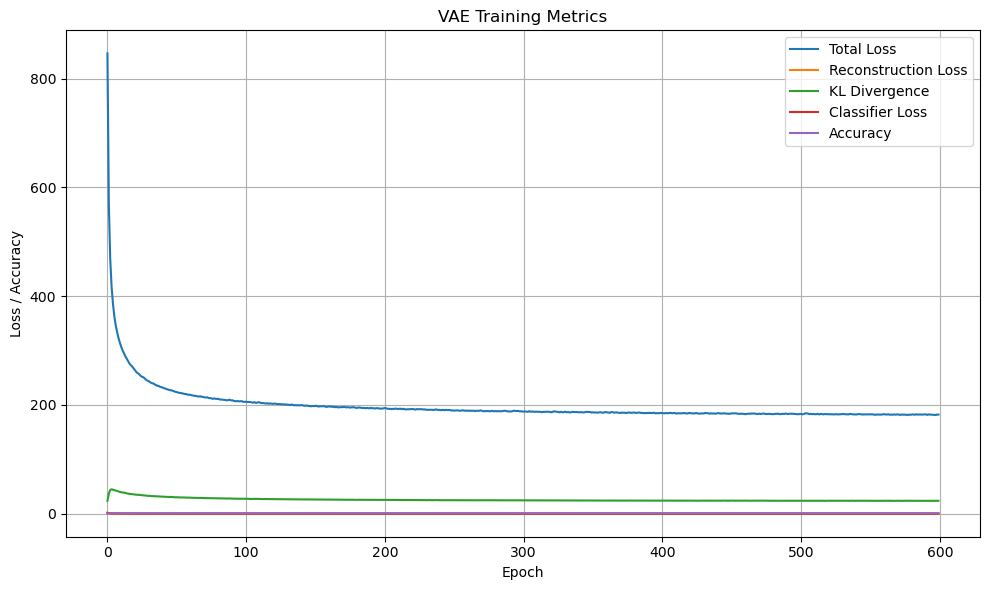

Saved latent z and labels y to latent_embeddings.npz


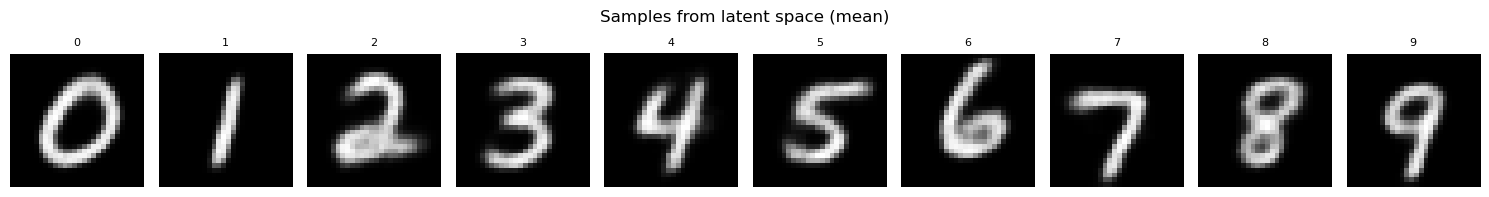

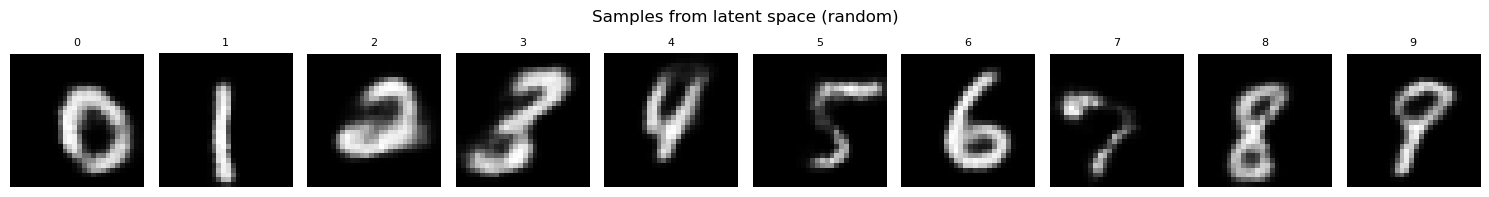

In [98]:
# === ConvVAE with Latent Classifier (MNIST, 2D) with Validation and Augmentation ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 1. Load MNIST Dataset with Augmentation =====
augment = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([transforms.ToTensor()])

mnist_full = datasets.MNIST(root="./data", train=True, download=True, transform=augment)
val_size = 10000
train_size = len(mnist_full) - val_size
train_data, val_data = random_split(mnist_full, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=3000, shuffle=True)
val_loader = DataLoader(val_data, batch_size=3000, shuffle=False)

# ===== 2. ConvVAE Definition (2D latent) =====
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

        self.classifier = nn.Linear(latent_dim, n_classes)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits, z

# ===== 3. Loss Function =====
def loss_fn(x, recon, mu, logvar, logits, y):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='mean')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    cls_loss = F.cross_entropy(logits, y)
    return 1000*recon_loss + kl + 200*cls_loss, recon_loss, kl, cls_loss

# ===== 4. Train Model and Save Latents =====
model = ConvVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

zs, ys = [], []
train_losses, recon_losses, kl_losses, cls_losses, accuracies = [], [], [], [], []

model.train()
for epoch in range(600):
    total_loss = total_recon = total_kl = total_cls = correct = total_samples = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, logits, z = model(x)
        loss, recon_loss, kl_loss, cls_loss = loss_fn(x, recon, mu, logvar, logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
        total_cls += cls_loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_samples += y.size(0)

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon / len(train_loader)
    avg_kl = total_kl / len(train_loader)
    avg_cls = total_cls / len(train_loader)
    accuracy = correct / total_samples

    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    cls_losses.append(avg_cls)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1:02d} | Total: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | Cls: {avg_cls:.4f} | Acc: {accuracy:.4f}")

    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            _, _, _, _, z = model(x)
            zs.append(z.cpu())
            ys.append(y)
    model.train()


# ===== Save the Trained ConvVAE Model =====
torch.save(model.state_dict(), "conv_vae_with_classifier.pth")
print("✅ Saved ConvVAE model to 'conv_vae_with_classifier.pth'")

# ===== Plot Training Curves =====
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(kl_losses, label="KL Divergence")
plt.plot(cls_losses, label="Classifier Loss")
plt.plot(accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.title("VAE Training Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vae_training_metrics.png", dpi=300)
plt.show()

# ===== Save z and y =====
z_all = torch.cat(zs).numpy()
y_all = torch.cat(ys).numpy()
np.savez("latent_embeddings.npz", z=z_all, y=y_all)
print("Saved latent z and labels y to latent_embeddings.npz")



# ===== Sample from Latent Clusters =====
def sample_from_clusters(model, z_vals, y_vals, n_per_class=5, method="mean"):
    model.eval()
    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    z_vals = torch.tensor(z_vals, dtype=torch.float32).to(device)
    y_vals = np.array(y_vals)

    for digit in range(10):
        idx = np.where(y_vals == digit)[0]
        if method == "mean":
            z_sample = z_vals[idx].mean(dim=0, keepdim=True).repeat(n_per_class, 1)
        elif method == "random":
            chosen = np.random.choice(idx, n_per_class)
            z_sample = z_vals[chosen]
        else:
            raise ValueError("method must be 'mean' or 'random'")

        with torch.no_grad():
            x_gen = model.decode(z_sample).cpu()

        for i in range(n_per_class):
            axs[digit].imshow(x_gen[i, 0], cmap="gray")
            axs[digit].axis("off")
            axs[digit].set_title(str(digit), fontsize=8)

    plt.suptitle(f"Samples from latent space ({method})")
    plt.tight_layout()
    plt.savefig(f"cluster_samples_{method}.png", dpi=300)
    plt.show()

# Call sampling function
sample_from_clusters(model, z_all, y_all, method="mean")
sample_from_clusters(model, z_all, y_all, method="random")




In [71]:
# === Train Conditional Diffusion Model on VAE Embeddings with Classifier-Based Guidance ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Load Latent Data from VAE =====
data = np.load("latent_embeddings.npz")
z_all = torch.tensor(data['z'], dtype=torch.float32)
y_all = torch.tensor(data['y'], dtype=torch.long)

# ===== Store mean/std but DO NOT normalize z_all for training =====
z_mean, z_std = z_all.mean(0, keepdim=True), z_all.std(0, keepdim=True)

# ===== Train Separate Linear Classifier on Raw z_all =====
class ZClassifier(nn.Module):
    def __init__(self, dim_z=20, num_classes=10):
        super().__init__()
        self.linear = nn.Linear(dim_z, num_classes)

    def forward(self, z):
        return self.linear(z)

z_classifier = ZClassifier().to(z_all.device)
clf_optimizer = torch.optim.Adam(z_classifier.parameters(), lr=1e-3)
clf_criterion = nn.CrossEntropyLoss()
clf_loader = DataLoader(TensorDataset(z_all, y_all), batch_size=256, shuffle=True)

for epoch in range(10):
    total_loss, correct, total = 0, 0, 0
    z_classifier.train()
    for z, y in clf_loader:
        z, y = z.to(z_all.device), y.to(z_all.device)
        logits = z_classifier(z)
        loss = clf_criterion(logits, y)
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()
        total_loss += loss.item()
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    acc = correct / total
    print(f"Z Classifier Epoch {epoch+1}: Loss={total_loss/len(clf_loader):.4f}, Acc={acc:.4f}")




Z Classifier Epoch 1: Loss=0.1167, Acc=0.9706
Z Classifier Epoch 2: Loss=0.0880, Acc=0.9755
Z Classifier Epoch 3: Loss=0.0880, Acc=0.9755
Z Classifier Epoch 4: Loss=0.0880, Acc=0.9755
Z Classifier Epoch 5: Loss=0.0880, Acc=0.9755
Z Classifier Epoch 6: Loss=0.0880, Acc=0.9755
Z Classifier Epoch 7: Loss=0.0880, Acc=0.9755
Z Classifier Epoch 8: Loss=0.0880, Acc=0.9755
Z Classifier Epoch 9: Loss=0.0880, Acc=0.9755
Z Classifier Epoch 10: Loss=0.0880, Acc=0.9755


In [ ]:
# ===== Sample 10 Unique Points per Class Without Replacement from z_all[:1000] =====
z_subset = z_all
y_subset = y_all

selected_z, selected_y = [], []
for digit in range(10):
    idx = (y_subset == digit).nonzero(as_tuple=True)[0]
    chosen = idx[torch.randperm(len(idx))[:1000]]  # 10 samples per class
    selected_z.append(z_subset[chosen])
    selected_y.append(y_subset[chosen])

z_sampled = torch.cat(selected_z, dim=0)
y_sampled = torch.cat(selected_y, dim=0)

print(f"✅ Sampled {z_sampled.shape[0]} points across all classes without replacement.")


from sklearn.decomposition import PCA

# Convert to NumPy for PCA
z_np = z_sampled.cpu().numpy()
y_np = y_sampled.cpu().numpy()

# Fit and transform with PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_np)

# Plot
plt.figure(figsize=(8, 6))
for digit in range(10):
    idx = y_np == digit
    plt.scatter(z_pca[idx, 0], z_pca[idx, 1], label=str(digit), alpha=0.6, s=10)

plt.legend(title="Digit")
plt.title("PCA of Sampled Latent Points (10,000 total)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_10000_latents.png", dpi=300)
plt.show()


import umap
import seaborn as sns

# ===== Apply UMAP =====
umap_model = umap.UMAP(n_components=2, random_state=42)
z_umap = umap_model.fit_transform(z_sampled)

# ===== Plot =====
plt.figure(figsize=(8, 6))
palette = sns.color_palette("tab10", 10)
for digit in range(10):
    idx = y_sampled == digit
    plt.scatter(z_umap[idx, 0], z_umap[idx, 1], label=str(digit), alpha=0.6, s=10, color=palette[digit])

plt.legend(title="Digit")
plt.title("UMAP of Latent Space (10k points, 1000/class)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("umap_10000_latents.png", dpi=300)
plt.show()

Epoch 1: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 259.87it/s]


Epoch 1: Loss = 0.9963


Epoch 2: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 312.20it/s]


Epoch 2: Loss = 0.9877


Epoch 3: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 314.29it/s]


Epoch 3: Loss = 0.9811


Epoch 4: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 315.85it/s]


Epoch 4: Loss = 0.9718


Epoch 5: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 315.15it/s]


Epoch 5: Loss = 0.9732


Epoch 6: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 311.82it/s]


Epoch 6: Loss = 0.9589


Epoch 7: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 305.51it/s]


Epoch 7: Loss = 0.9480


Epoch 8: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 309.22it/s]


Epoch 8: Loss = 0.9355


Epoch 9: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 305.04it/s]


Epoch 9: Loss = 0.9216


Epoch 10: 100%|████████████████████████████████| 40/40 [00:00<00:00, 309.20it/s]


Epoch 10: Loss = 0.8997


Epoch 11: 100%|████████████████████████████████| 40/40 [00:00<00:00, 306.56it/s]


Epoch 11: Loss = 0.8759


Epoch 12: 100%|████████████████████████████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 12: Loss = 0.8494


Epoch 13: 100%|████████████████████████████████| 40/40 [00:00<00:00, 315.81it/s]


Epoch 13: Loss = 0.7941


Epoch 14: 100%|████████████████████████████████| 40/40 [00:00<00:00, 302.39it/s]


Epoch 14: Loss = 0.7103


Epoch 15: 100%|████████████████████████████████| 40/40 [00:00<00:00, 294.67it/s]


Epoch 15: Loss = 0.5885


Epoch 16: 100%|████████████████████████████████| 40/40 [00:00<00:00, 296.67it/s]


Epoch 16: Loss = 0.4372


Epoch 17: 100%|████████████████████████████████| 40/40 [00:00<00:00, 303.15it/s]


Epoch 17: Loss = 0.3025


Epoch 18: 100%|████████████████████████████████| 40/40 [00:00<00:00, 310.09it/s]


Epoch 18: Loss = 0.2197


Epoch 19: 100%|████████████████████████████████| 40/40 [00:00<00:00, 311.88it/s]


Epoch 19: Loss = 0.1649


Epoch 20: 100%|████████████████████████████████| 40/40 [00:00<00:00, 313.36it/s]


Epoch 20: Loss = 0.1343


Epoch 21: 100%|████████████████████████████████| 40/40 [00:00<00:00, 313.09it/s]


Epoch 21: Loss = 0.1202


Epoch 22: 100%|████████████████████████████████| 40/40 [00:00<00:00, 310.56it/s]


Epoch 22: Loss = 0.1035


Epoch 23: 100%|████████████████████████████████| 40/40 [00:00<00:00, 307.91it/s]


Epoch 23: Loss = 0.0958


Epoch 24: 100%|████████████████████████████████| 40/40 [00:00<00:00, 309.00it/s]


Epoch 24: Loss = 0.0904


Epoch 25: 100%|████████████████████████████████| 40/40 [00:00<00:00, 308.36it/s]


Epoch 25: Loss = 0.0933


Epoch 26: 100%|████████████████████████████████| 40/40 [00:00<00:00, 308.64it/s]


Epoch 26: Loss = 0.0852


Epoch 27: 100%|████████████████████████████████| 40/40 [00:00<00:00, 306.54it/s]


Epoch 27: Loss = 0.0898


Epoch 28: 100%|████████████████████████████████| 40/40 [00:00<00:00, 302.71it/s]


Epoch 28: Loss = 0.0832


Epoch 29: 100%|████████████████████████████████| 40/40 [00:00<00:00, 292.90it/s]


Epoch 29: Loss = 0.0872


Epoch 30: 100%|████████████████████████████████| 40/40 [00:00<00:00, 302.78it/s]


Epoch 30: Loss = 0.0799


Epoch 31: 100%|████████████████████████████████| 40/40 [00:00<00:00, 292.79it/s]


Epoch 31: Loss = 0.0889


Epoch 32: 100%|████████████████████████████████| 40/40 [00:00<00:00, 298.13it/s]


Epoch 32: Loss = 0.0882


Epoch 33: 100%|████████████████████████████████| 40/40 [00:00<00:00, 297.44it/s]


Epoch 33: Loss = 0.0841


Epoch 34: 100%|████████████████████████████████| 40/40 [00:00<00:00, 289.60it/s]


Epoch 34: Loss = 0.0830


Epoch 35: 100%|████████████████████████████████| 40/40 [00:00<00:00, 293.69it/s]


Epoch 35: Loss = 0.0855


Epoch 36: 100%|████████████████████████████████| 40/40 [00:00<00:00, 301.51it/s]


Epoch 36: Loss = 0.0754


Epoch 37: 100%|████████████████████████████████| 40/40 [00:00<00:00, 295.71it/s]


Epoch 37: Loss = 0.0819


Epoch 38: 100%|████████████████████████████████| 40/40 [00:00<00:00, 295.34it/s]


Epoch 38: Loss = 0.0846


Epoch 39: 100%|████████████████████████████████| 40/40 [00:00<00:00, 298.35it/s]


Epoch 39: Loss = 0.0846


Epoch 40: 100%|████████████████████████████████| 40/40 [00:00<00:00, 293.79it/s]


Epoch 40: Loss = 0.0856


Epoch 41: 100%|████████████████████████████████| 40/40 [00:00<00:00, 292.71it/s]


Epoch 41: Loss = 0.0866


Epoch 42: 100%|████████████████████████████████| 40/40 [00:00<00:00, 299.86it/s]


Epoch 42: Loss = 0.0830


Epoch 43: 100%|████████████████████████████████| 40/40 [00:00<00:00, 288.84it/s]


Epoch 43: Loss = 0.0914


Epoch 44: 100%|████████████████████████████████| 40/40 [00:00<00:00, 287.99it/s]


Epoch 44: Loss = 0.0814


Epoch 45: 100%|████████████████████████████████| 40/40 [00:00<00:00, 278.44it/s]


Epoch 45: Loss = 0.0846


Epoch 46: 100%|████████████████████████████████| 40/40 [00:00<00:00, 274.25it/s]


Epoch 46: Loss = 0.0790


Epoch 47: 100%|████████████████████████████████| 40/40 [00:00<00:00, 284.78it/s]


Epoch 47: Loss = 0.0835


Epoch 48: 100%|████████████████████████████████| 40/40 [00:00<00:00, 299.08it/s]


Epoch 48: Loss = 0.0799


Epoch 49: 100%|████████████████████████████████| 40/40 [00:00<00:00, 302.43it/s]


Epoch 49: Loss = 0.0828


Epoch 50: 100%|████████████████████████████████| 40/40 [00:00<00:00, 298.93it/s]


Epoch 50: Loss = 0.0833


Epoch 51: 100%|████████████████████████████████| 40/40 [00:00<00:00, 278.70it/s]


Epoch 51: Loss = 0.0811


Epoch 52: 100%|████████████████████████████████| 40/40 [00:00<00:00, 259.26it/s]


Epoch 52: Loss = 0.0823


Epoch 53: 100%|████████████████████████████████| 40/40 [00:00<00:00, 247.70it/s]


Epoch 53: Loss = 0.0835


Epoch 54: 100%|████████████████████████████████| 40/40 [00:00<00:00, 242.51it/s]


Epoch 54: Loss = 0.0923


Epoch 55: 100%|████████████████████████████████| 40/40 [00:00<00:00, 262.09it/s]


Epoch 55: Loss = 0.0836


Epoch 56: 100%|████████████████████████████████| 40/40 [00:00<00:00, 245.09it/s]


Epoch 56: Loss = 0.0824


Epoch 57: 100%|████████████████████████████████| 40/40 [00:00<00:00, 271.60it/s]


Epoch 57: Loss = 0.0785


Epoch 58: 100%|████████████████████████████████| 40/40 [00:00<00:00, 261.29it/s]


Epoch 58: Loss = 0.0882


Epoch 59: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 97.87it/s]


Epoch 59: Loss = 0.0817


Epoch 60: 100%|████████████████████████████████| 40/40 [00:00<00:00, 242.84it/s]


Epoch 60: Loss = 0.0806


Epoch 61: 100%|████████████████████████████████| 40/40 [00:00<00:00, 243.05it/s]


Epoch 61: Loss = 0.0791


Epoch 62: 100%|████████████████████████████████| 40/40 [00:00<00:00, 253.00it/s]


Epoch 62: Loss = 0.0717


Epoch 63: 100%|████████████████████████████████| 40/40 [00:00<00:00, 121.15it/s]


Epoch 63: Loss = 0.0777


Epoch 64: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 77.15it/s]


Epoch 64: Loss = 0.0787


Epoch 65: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 73.94it/s]


Epoch 65: Loss = 0.0779


Epoch 66: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 75.74it/s]


Epoch 66: Loss = 0.0817


Epoch 67: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 70.14it/s]


Epoch 67: Loss = 0.0811


Epoch 68: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 69.72it/s]


Epoch 68: Loss = 0.0765


Epoch 69: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 70.12it/s]


Epoch 69: Loss = 0.0768


Epoch 70: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 80.60it/s]


Epoch 70: Loss = 0.0759


Epoch 71: 100%|████████████████████████████████| 40/40 [00:00<00:00, 184.37it/s]


Epoch 71: Loss = 0.0770


Epoch 72: 100%|████████████████████████████████| 40/40 [00:00<00:00, 202.67it/s]


Epoch 72: Loss = 0.0787


Epoch 73: 100%|████████████████████████████████| 40/40 [00:00<00:00, 226.89it/s]


Epoch 73: Loss = 0.0843


Epoch 74: 100%|████████████████████████████████| 40/40 [00:00<00:00, 231.73it/s]


Epoch 74: Loss = 0.0832


Epoch 75: 100%|████████████████████████████████| 40/40 [00:00<00:00, 214.77it/s]


Epoch 75: Loss = 0.0750


Epoch 76: 100%|████████████████████████████████| 40/40 [00:00<00:00, 216.28it/s]


Epoch 76: Loss = 0.0797


Epoch 77: 100%|████████████████████████████████| 40/40 [00:00<00:00, 247.34it/s]


Epoch 77: Loss = 0.0855


Epoch 78: 100%|████████████████████████████████| 40/40 [00:00<00:00, 224.49it/s]


Epoch 78: Loss = 0.0768


Epoch 79: 100%|████████████████████████████████| 40/40 [00:00<00:00, 103.37it/s]


Epoch 79: Loss = 0.0798


Epoch 80: 100%|████████████████████████████████| 40/40 [00:00<00:00, 189.36it/s]


Epoch 80: Loss = 0.0845


Epoch 81: 100%|████████████████████████████████| 40/40 [00:00<00:00, 219.19it/s]


Epoch 81: Loss = 0.0726


Epoch 82: 100%|████████████████████████████████| 40/40 [00:00<00:00, 228.34it/s]


Epoch 82: Loss = 0.0778


Epoch 83: 100%|████████████████████████████████| 40/40 [00:00<00:00, 236.02it/s]


Epoch 83: Loss = 0.0779


Epoch 84: 100%|████████████████████████████████| 40/40 [00:00<00:00, 255.00it/s]


Epoch 84: Loss = 0.0764


Epoch 85: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 98.03it/s]


Epoch 85: Loss = 0.0790


Epoch 86: 100%|████████████████████████████████| 40/40 [00:00<00:00, 137.22it/s]


Epoch 86: Loss = 0.0762


Epoch 87: 100%|████████████████████████████████| 40/40 [00:00<00:00, 203.27it/s]


Epoch 87: Loss = 0.0791


Epoch 88: 100%|████████████████████████████████| 40/40 [00:00<00:00, 215.89it/s]


Epoch 88: Loss = 0.0782


Epoch 89: 100%|████████████████████████████████| 40/40 [00:00<00:00, 205.19it/s]


Epoch 89: Loss = 0.0735


Epoch 90: 100%|████████████████████████████████| 40/40 [00:00<00:00, 241.42it/s]


Epoch 90: Loss = 0.0758


Epoch 91: 100%|████████████████████████████████| 40/40 [00:00<00:00, 264.57it/s]


Epoch 91: Loss = 0.0758


Epoch 92: 100%|████████████████████████████████| 40/40 [00:00<00:00, 269.59it/s]


Epoch 92: Loss = 0.0771


Epoch 93: 100%|████████████████████████████████| 40/40 [00:00<00:00, 273.79it/s]


Epoch 93: Loss = 0.0742


Epoch 94: 100%|████████████████████████████████| 40/40 [00:00<00:00, 273.91it/s]


Epoch 94: Loss = 0.0752


Epoch 95: 100%|████████████████████████████████| 40/40 [00:00<00:00, 272.80it/s]


Epoch 95: Loss = 0.0738


Epoch 96: 100%|████████████████████████████████| 40/40 [00:00<00:00, 274.81it/s]


Epoch 96: Loss = 0.0760


Epoch 97: 100%|████████████████████████████████| 40/40 [00:00<00:00, 272.79it/s]


Epoch 97: Loss = 0.0756


Epoch 98: 100%|████████████████████████████████| 40/40 [00:00<00:00, 277.07it/s]


Epoch 98: Loss = 0.0770


Epoch 99: 100%|████████████████████████████████| 40/40 [00:00<00:00, 237.08it/s]


Epoch 99: Loss = 0.0821


Epoch 100: 100%|███████████████████████████████| 40/40 [00:00<00:00, 260.02it/s]


Epoch 100: Loss = 0.0767


Epoch 101: 100%|███████████████████████████████| 40/40 [00:00<00:00, 275.13it/s]


Epoch 101: Loss = 0.0791


Epoch 102: 100%|███████████████████████████████| 40/40 [00:00<00:00, 176.05it/s]


Epoch 102: Loss = 0.0791


Epoch 103: 100%|███████████████████████████████| 40/40 [00:00<00:00, 264.65it/s]


Epoch 103: Loss = 0.0722


Epoch 104: 100%|███████████████████████████████| 40/40 [00:00<00:00, 272.61it/s]


Epoch 104: Loss = 0.0765


Epoch 105: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.19it/s]


Epoch 105: Loss = 0.0769


Epoch 106: 100%|███████████████████████████████| 40/40 [00:00<00:00, 288.41it/s]


Epoch 106: Loss = 0.0759


Epoch 107: 100%|███████████████████████████████| 40/40 [00:00<00:00, 288.26it/s]


Epoch 107: Loss = 0.0789


Epoch 108: 100%|███████████████████████████████| 40/40 [00:00<00:00, 285.21it/s]


Epoch 108: Loss = 0.0800


Epoch 109: 100%|███████████████████████████████| 40/40 [00:00<00:00, 288.71it/s]


Epoch 109: Loss = 0.0766


Epoch 110: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.46it/s]


Epoch 110: Loss = 0.0750


Epoch 111: 100%|███████████████████████████████| 40/40 [00:00<00:00, 285.49it/s]


Epoch 111: Loss = 0.0740


Epoch 112: 100%|███████████████████████████████| 40/40 [00:00<00:00, 295.67it/s]


Epoch 112: Loss = 0.0737


Epoch 113: 100%|███████████████████████████████| 40/40 [00:00<00:00, 292.25it/s]


Epoch 113: Loss = 0.0709


Epoch 114: 100%|███████████████████████████████| 40/40 [00:00<00:00, 274.54it/s]


Epoch 114: Loss = 0.0814


Epoch 115: 100%|███████████████████████████████| 40/40 [00:00<00:00, 292.44it/s]


Epoch 115: Loss = 0.0782


Epoch 116: 100%|███████████████████████████████| 40/40 [00:00<00:00, 295.43it/s]


Epoch 116: Loss = 0.0686


Epoch 117: 100%|███████████████████████████████| 40/40 [00:00<00:00, 128.79it/s]


Epoch 117: Loss = 0.0724


Epoch 118: 100%|███████████████████████████████| 40/40 [00:00<00:00, 315.20it/s]


Epoch 118: Loss = 0.0729


Epoch 119: 100%|███████████████████████████████| 40/40 [00:00<00:00, 307.44it/s]


Epoch 119: Loss = 0.0682


Epoch 120: 100%|███████████████████████████████| 40/40 [00:00<00:00, 305.40it/s]


Epoch 120: Loss = 0.0746


Epoch 121: 100%|███████████████████████████████| 40/40 [00:00<00:00, 293.42it/s]


Epoch 121: Loss = 0.0714


Epoch 122: 100%|███████████████████████████████| 40/40 [00:00<00:00, 291.63it/s]


Epoch 122: Loss = 0.0783


Epoch 123: 100%|███████████████████████████████| 40/40 [00:00<00:00, 294.01it/s]


Epoch 123: Loss = 0.0772


Epoch 124: 100%|███████████████████████████████| 40/40 [00:00<00:00, 293.66it/s]


Epoch 124: Loss = 0.0726


Epoch 125: 100%|███████████████████████████████| 40/40 [00:00<00:00, 298.87it/s]


Epoch 125: Loss = 0.0704


Epoch 126: 100%|███████████████████████████████| 40/40 [00:00<00:00, 296.95it/s]


Epoch 126: Loss = 0.0659


Epoch 127: 100%|███████████████████████████████| 40/40 [00:00<00:00, 298.73it/s]


Epoch 127: Loss = 0.0721


Epoch 128: 100%|███████████████████████████████| 40/40 [00:00<00:00, 295.61it/s]


Epoch 128: Loss = 0.0697


Epoch 129: 100%|███████████████████████████████| 40/40 [00:00<00:00, 295.90it/s]


Epoch 129: Loss = 0.0730


Epoch 130: 100%|███████████████████████████████| 40/40 [00:00<00:00, 296.13it/s]


Epoch 130: Loss = 0.0750


Epoch 131: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.93it/s]


Epoch 131: Loss = 0.0771


Epoch 132: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.12it/s]


Epoch 132: Loss = 0.0746


Epoch 133: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.06it/s]


Epoch 133: Loss = 0.0724


Epoch 134: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.50it/s]


Epoch 134: Loss = 0.0754


Epoch 135: 100%|███████████████████████████████| 40/40 [00:00<00:00, 187.49it/s]


Epoch 135: Loss = 0.0789


Epoch 136: 100%|████████████████████████████████| 40/40 [00:00<00:00, 77.33it/s]


Epoch 136: Loss = 0.0725


Epoch 137: 100%|████████████████████████████████| 40/40 [00:00<00:00, 70.34it/s]


Epoch 137: Loss = 0.0729


Epoch 138: 100%|████████████████████████████████| 40/40 [00:00<00:00, 70.36it/s]


Epoch 138: Loss = 0.0728


Epoch 139: 100%|████████████████████████████████| 40/40 [00:00<00:00, 69.49it/s]


Epoch 139: Loss = 0.0713


Epoch 140: 100%|████████████████████████████████| 40/40 [00:00<00:00, 70.08it/s]


Epoch 140: Loss = 0.0709


Epoch 141: 100%|████████████████████████████████| 40/40 [00:00<00:00, 68.42it/s]


Epoch 141: Loss = 0.0724


Epoch 142: 100%|████████████████████████████████| 40/40 [00:00<00:00, 72.44it/s]


Epoch 142: Loss = 0.0720


Epoch 143: 100%|███████████████████████████████| 40/40 [00:00<00:00, 217.98it/s]


Epoch 143: Loss = 0.0739


Epoch 144: 100%|███████████████████████████████| 40/40 [00:00<00:00, 225.07it/s]


Epoch 144: Loss = 0.0661


Epoch 145: 100%|███████████████████████████████| 40/40 [00:00<00:00, 243.58it/s]


Epoch 145: Loss = 0.0742


Epoch 146: 100%|███████████████████████████████| 40/40 [00:00<00:00, 251.81it/s]


Epoch 146: Loss = 0.0739


Epoch 147: 100%|███████████████████████████████| 40/40 [00:00<00:00, 233.16it/s]


Epoch 147: Loss = 0.0688


Epoch 148: 100%|███████████████████████████████| 40/40 [00:00<00:00, 222.29it/s]


Epoch 148: Loss = 0.0714


Epoch 149: 100%|███████████████████████████████| 40/40 [00:00<00:00, 253.48it/s]


Epoch 149: Loss = 0.0701


Epoch 150: 100%|███████████████████████████████| 40/40 [00:00<00:00, 229.99it/s]


Epoch 150: Loss = 0.0714


Epoch 151: 100%|███████████████████████████████| 40/40 [00:00<00:00, 231.20it/s]


Epoch 151: Loss = 0.0681


Epoch 152: 100%|███████████████████████████████| 40/40 [00:00<00:00, 236.11it/s]


Epoch 152: Loss = 0.0701


Epoch 153: 100%|███████████████████████████████| 40/40 [00:00<00:00, 265.40it/s]


Epoch 153: Loss = 0.0718


Epoch 154: 100%|███████████████████████████████| 40/40 [00:00<00:00, 260.24it/s]


Epoch 154: Loss = 0.0692


Epoch 155: 100%|███████████████████████████████| 40/40 [00:00<00:00, 262.90it/s]


Epoch 155: Loss = 0.0662


Epoch 156: 100%|████████████████████████████████| 40/40 [00:00<00:00, 97.52it/s]


Epoch 156: Loss = 0.0748


Epoch 157: 100%|███████████████████████████████| 40/40 [00:00<00:00, 200.50it/s]


Epoch 157: Loss = 0.0685


Epoch 158: 100%|███████████████████████████████| 40/40 [00:00<00:00, 282.02it/s]


Epoch 158: Loss = 0.0701


Epoch 159: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.80it/s]


Epoch 159: Loss = 0.0708


Epoch 160: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.04it/s]


Epoch 160: Loss = 0.0691


Epoch 161: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.42it/s]


Epoch 161: Loss = 0.0686


Epoch 162: 100%|███████████████████████████████| 40/40 [00:00<00:00, 278.63it/s]


Epoch 162: Loss = 0.0732


Epoch 163: 100%|███████████████████████████████| 40/40 [00:00<00:00, 278.94it/s]


Epoch 163: Loss = 0.0671


Epoch 164: 100%|███████████████████████████████| 40/40 [00:00<00:00, 281.58it/s]


Epoch 164: Loss = 0.0699


Epoch 165: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.28it/s]


Epoch 165: Loss = 0.0725


Epoch 166: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.48it/s]


Epoch 166: Loss = 0.0700


Epoch 167: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.05it/s]


Epoch 167: Loss = 0.0650


Epoch 168: 100%|███████████████████████████████| 40/40 [00:00<00:00, 286.01it/s]


Epoch 168: Loss = 0.0676


Epoch 169: 100%|███████████████████████████████| 40/40 [00:00<00:00, 288.46it/s]


Epoch 169: Loss = 0.0676


Epoch 170: 100%|███████████████████████████████| 40/40 [00:00<00:00, 286.73it/s]


Epoch 170: Loss = 0.0704


Epoch 171: 100%|███████████████████████████████| 40/40 [00:00<00:00, 283.60it/s]


Epoch 171: Loss = 0.0717


Epoch 172: 100%|███████████████████████████████| 40/40 [00:00<00:00, 285.16it/s]


Epoch 172: Loss = 0.0697


Epoch 173: 100%|███████████████████████████████| 40/40 [00:00<00:00, 274.98it/s]


Epoch 173: Loss = 0.0647


Epoch 174: 100%|███████████████████████████████| 40/40 [00:00<00:00, 290.82it/s]


Epoch 174: Loss = 0.0728


Epoch 175: 100%|███████████████████████████████| 40/40 [00:00<00:00, 283.78it/s]


Epoch 175: Loss = 0.0671


Epoch 176: 100%|███████████████████████████████| 40/40 [00:00<00:00, 286.24it/s]


Epoch 176: Loss = 0.0660


Epoch 177: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.78it/s]


Epoch 177: Loss = 0.0669


Epoch 178: 100%|███████████████████████████████| 40/40 [00:00<00:00, 285.78it/s]


Epoch 178: Loss = 0.0685


Epoch 179: 100%|███████████████████████████████| 40/40 [00:00<00:00, 287.47it/s]


Epoch 179: Loss = 0.0673


Epoch 180: 100%|███████████████████████████████| 40/40 [00:00<00:00, 289.40it/s]


Epoch 180: Loss = 0.0689


Epoch 181: 100%|███████████████████████████████| 40/40 [00:00<00:00, 287.55it/s]


Epoch 181: Loss = 0.0698


Epoch 182: 100%|███████████████████████████████| 40/40 [00:00<00:00, 287.24it/s]


Epoch 182: Loss = 0.0645


Epoch 183: 100%|███████████████████████████████| 40/40 [00:00<00:00, 293.61it/s]


Epoch 183: Loss = 0.0670


Epoch 184: 100%|███████████████████████████████| 40/40 [00:00<00:00, 292.66it/s]


Epoch 184: Loss = 0.0656


Epoch 185: 100%|███████████████████████████████| 40/40 [00:00<00:00, 284.18it/s]


Epoch 185: Loss = 0.0681


Epoch 186: 100%|███████████████████████████████| 40/40 [00:00<00:00, 289.43it/s]


Epoch 186: Loss = 0.0649


Epoch 187: 100%|███████████████████████████████| 40/40 [00:00<00:00, 290.76it/s]


Epoch 187: Loss = 0.0719


Epoch 188: 100%|███████████████████████████████| 40/40 [00:00<00:00, 283.93it/s]


Epoch 188: Loss = 0.0683


Epoch 189: 100%|███████████████████████████████| 40/40 [00:00<00:00, 287.31it/s]


Epoch 189: Loss = 0.0681


Epoch 190: 100%|███████████████████████████████| 40/40 [00:00<00:00, 288.90it/s]


Epoch 190: Loss = 0.0675


Epoch 191: 100%|███████████████████████████████| 40/40 [00:00<00:00, 290.41it/s]


Epoch 191: Loss = 0.0638


Epoch 192: 100%|███████████████████████████████| 40/40 [00:00<00:00, 291.42it/s]


Epoch 192: Loss = 0.0671


Epoch 193: 100%|███████████████████████████████| 40/40 [00:00<00:00, 294.73it/s]


Epoch 193: Loss = 0.0671


Epoch 194: 100%|███████████████████████████████| 40/40 [00:00<00:00, 227.84it/s]


Epoch 194: Loss = 0.0679


Epoch 195: 100%|███████████████████████████████| 40/40 [00:00<00:00, 290.24it/s]


Epoch 195: Loss = 0.0672


Epoch 196: 100%|███████████████████████████████| 40/40 [00:00<00:00, 291.97it/s]


Epoch 196: Loss = 0.0695


Epoch 197: 100%|███████████████████████████████| 40/40 [00:00<00:00, 285.66it/s]


Epoch 197: Loss = 0.0668


Epoch 198: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.99it/s]


Epoch 198: Loss = 0.0648


Epoch 199: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.44it/s]


Epoch 199: Loss = 0.0659


Epoch 200: 100%|███████████████████████████████| 40/40 [00:00<00:00, 282.05it/s]


Epoch 200: Loss = 0.0691


Epoch 201: 100%|███████████████████████████████| 40/40 [00:00<00:00, 292.55it/s]


Epoch 201: Loss = 0.0680


Epoch 202: 100%|███████████████████████████████| 40/40 [00:00<00:00, 293.96it/s]


Epoch 202: Loss = 0.0619


Epoch 203: 100%|███████████████████████████████| 40/40 [00:00<00:00, 283.15it/s]


Epoch 203: Loss = 0.0646


Epoch 204: 100%|███████████████████████████████| 40/40 [00:00<00:00, 251.97it/s]


Epoch 204: Loss = 0.0673


Epoch 205: 100%|███████████████████████████████| 40/40 [00:00<00:00, 252.85it/s]


Epoch 205: Loss = 0.0666


Epoch 206: 100%|███████████████████████████████| 40/40 [00:00<00:00, 256.80it/s]


Epoch 206: Loss = 0.0674


Epoch 207: 100%|███████████████████████████████| 40/40 [00:00<00:00, 249.31it/s]


Epoch 207: Loss = 0.0678


Epoch 208: 100%|███████████████████████████████| 40/40 [00:00<00:00, 101.47it/s]


Epoch 208: Loss = 0.0669


Epoch 209: 100%|████████████████████████████████| 40/40 [00:00<00:00, 69.93it/s]


Epoch 209: Loss = 0.0652


Epoch 210: 100%|████████████████████████████████| 40/40 [00:00<00:00, 69.95it/s]


Epoch 210: Loss = 0.0639


Epoch 211: 100%|████████████████████████████████| 40/40 [00:00<00:00, 69.96it/s]


Epoch 211: Loss = 0.0681


Epoch 212: 100%|████████████████████████████████| 40/40 [00:00<00:00, 70.34it/s]


Epoch 212: Loss = 0.0640


Epoch 213: 100%|████████████████████████████████| 40/40 [00:00<00:00, 72.81it/s]


Epoch 213: Loss = 0.0687


Epoch 214: 100%|████████████████████████████████| 40/40 [00:00<00:00, 66.34it/s]


Epoch 214: Loss = 0.0670


Epoch 215: 100%|███████████████████████████████| 40/40 [00:00<00:00, 128.62it/s]


Epoch 215: Loss = 0.0649


Epoch 216: 100%|███████████████████████████████| 40/40 [00:00<00:00, 200.15it/s]


Epoch 216: Loss = 0.0641


Epoch 217: 100%|███████████████████████████████| 40/40 [00:00<00:00, 212.49it/s]


Epoch 217: Loss = 0.0639


Epoch 218: 100%|███████████████████████████████| 40/40 [00:00<00:00, 224.78it/s]


Epoch 218: Loss = 0.0630


Epoch 219: 100%|███████████████████████████████| 40/40 [00:00<00:00, 221.87it/s]


Epoch 219: Loss = 0.0658


Epoch 220: 100%|███████████████████████████████| 40/40 [00:00<00:00, 229.13it/s]


Epoch 220: Loss = 0.0682


Epoch 221: 100%|████████████████████████████████| 40/40 [00:00<00:00, 84.93it/s]


Epoch 221: Loss = 0.0639


Epoch 222: 100%|███████████████████████████████| 40/40 [00:00<00:00, 224.89it/s]


Epoch 222: Loss = 0.0668


Epoch 223: 100%|███████████████████████████████| 40/40 [00:00<00:00, 242.02it/s]


Epoch 223: Loss = 0.0633


Epoch 224: 100%|███████████████████████████████| 40/40 [00:00<00:00, 259.54it/s]


Epoch 224: Loss = 0.0620


Epoch 225: 100%|███████████████████████████████| 40/40 [00:00<00:00, 261.71it/s]


Epoch 225: Loss = 0.0586


Epoch 226: 100%|███████████████████████████████| 40/40 [00:00<00:00, 171.08it/s]


Epoch 226: Loss = 0.0643


Epoch 227: 100%|████████████████████████████████| 40/40 [00:00<00:00, 83.18it/s]


Epoch 227: Loss = 0.0625


Epoch 228: 100%|███████████████████████████████| 40/40 [00:00<00:00, 291.79it/s]


Epoch 228: Loss = 0.0645


Epoch 229: 100%|███████████████████████████████| 40/40 [00:00<00:00, 285.82it/s]


Epoch 229: Loss = 0.0662


Epoch 230: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.41it/s]


Epoch 230: Loss = 0.0655


Epoch 231: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.26it/s]


Epoch 231: Loss = 0.0638


Epoch 232: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.87it/s]


Epoch 232: Loss = 0.0635


Epoch 233: 100%|███████████████████████████████| 40/40 [00:00<00:00, 274.61it/s]


Epoch 233: Loss = 0.0630


Epoch 234: 100%|███████████████████████████████| 40/40 [00:00<00:00, 275.63it/s]


Epoch 234: Loss = 0.0665


Epoch 235: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.79it/s]


Epoch 235: Loss = 0.0646


Epoch 236: 100%|███████████████████████████████| 40/40 [00:00<00:00, 273.30it/s]


Epoch 236: Loss = 0.0632


Epoch 237: 100%|███████████████████████████████| 40/40 [00:00<00:00, 274.89it/s]


Epoch 237: Loss = 0.0602


Epoch 238: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.87it/s]


Epoch 238: Loss = 0.0598


Epoch 239: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.41it/s]


Epoch 239: Loss = 0.0646


Epoch 240: 100%|███████████████████████████████| 40/40 [00:00<00:00, 275.76it/s]


Epoch 240: Loss = 0.0639


Epoch 241: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.64it/s]


Epoch 241: Loss = 0.0684


Epoch 242: 100%|███████████████████████████████| 40/40 [00:00<00:00, 255.86it/s]


Epoch 242: Loss = 0.0627


Epoch 243: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.17it/s]


Epoch 243: Loss = 0.0638


Epoch 244: 100%|███████████████████████████████| 40/40 [00:00<00:00, 272.89it/s]


Epoch 244: Loss = 0.0642


Epoch 245: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.82it/s]


Epoch 245: Loss = 0.0611


Epoch 246: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.82it/s]


Epoch 246: Loss = 0.0649


Epoch 247: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.20it/s]


Epoch 247: Loss = 0.0611


Epoch 248: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.74it/s]


Epoch 248: Loss = 0.0612


Epoch 249: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.10it/s]


Epoch 249: Loss = 0.0629


Epoch 250: 100%|███████████████████████████████| 40/40 [00:00<00:00, 274.04it/s]


Epoch 250: Loss = 0.0592


Epoch 251: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.40it/s]


Epoch 251: Loss = 0.0618


Epoch 252: 100%|███████████████████████████████| 40/40 [00:00<00:00, 282.06it/s]


Epoch 252: Loss = 0.0657


Epoch 253: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.66it/s]


Epoch 253: Loss = 0.0664


Epoch 254: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.41it/s]


Epoch 254: Loss = 0.0590


Epoch 255: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.73it/s]


Epoch 255: Loss = 0.0617


Epoch 256: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.57it/s]


Epoch 256: Loss = 0.0674


Epoch 257: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.41it/s]


Epoch 257: Loss = 0.0580


Epoch 258: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.60it/s]


Epoch 258: Loss = 0.0655


Epoch 259: 100%|███████████████████████████████| 40/40 [00:00<00:00, 265.60it/s]


Epoch 259: Loss = 0.0667


Epoch 260: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.20it/s]


Epoch 260: Loss = 0.0625


Epoch 261: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.58it/s]


Epoch 261: Loss = 0.0643


Epoch 262: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.03it/s]


Epoch 262: Loss = 0.0601


Epoch 263: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.36it/s]


Epoch 263: Loss = 0.0630


Epoch 264: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.37it/s]


Epoch 264: Loss = 0.0624


Epoch 265: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.54it/s]


Epoch 265: Loss = 0.0631


Epoch 266: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.03it/s]


Epoch 266: Loss = 0.0629


Epoch 267: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.96it/s]


Epoch 267: Loss = 0.0629


Epoch 268: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.40it/s]


Epoch 268: Loss = 0.0607


Epoch 269: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.64it/s]


Epoch 269: Loss = 0.0591


Epoch 270: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.24it/s]


Epoch 270: Loss = 0.0634


Epoch 271: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.24it/s]


Epoch 271: Loss = 0.0616


Epoch 272: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.75it/s]


Epoch 272: Loss = 0.0616


Epoch 273: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.23it/s]


Epoch 273: Loss = 0.0595


Epoch 274: 100%|███████████████████████████████| 40/40 [00:00<00:00, 246.35it/s]


Epoch 274: Loss = 0.0606


Epoch 275: 100%|███████████████████████████████| 40/40 [00:00<00:00, 234.99it/s]


Epoch 275: Loss = 0.0640


Epoch 276: 100%|███████████████████████████████| 40/40 [00:00<00:00, 238.49it/s]


Epoch 276: Loss = 0.0621


Epoch 277: 100%|███████████████████████████████| 40/40 [00:00<00:00, 234.10it/s]


Epoch 277: Loss = 0.0588


Epoch 278: 100%|████████████████████████████████| 40/40 [00:00<00:00, 76.95it/s]


Epoch 278: Loss = 0.0624


Epoch 279: 100%|████████████████████████████████| 40/40 [00:00<00:00, 69.13it/s]


Epoch 279: Loss = 0.0608


Epoch 280: 100%|████████████████████████████████| 40/40 [00:00<00:00, 69.39it/s]


Epoch 280: Loss = 0.0618


Epoch 281: 100%|████████████████████████████████| 40/40 [00:00<00:00, 70.32it/s]


Epoch 281: Loss = 0.0599


Epoch 282: 100%|████████████████████████████████| 40/40 [00:00<00:00, 72.61it/s]


Epoch 282: Loss = 0.0622


Epoch 283: 100%|████████████████████████████████| 40/40 [00:00<00:00, 71.79it/s]


Epoch 283: Loss = 0.0598


Epoch 284: 100%|████████████████████████████████| 40/40 [00:00<00:00, 68.67it/s]


Epoch 284: Loss = 0.0573


Epoch 285: 100%|███████████████████████████████| 40/40 [00:00<00:00, 107.89it/s]


Epoch 285: Loss = 0.0624


Epoch 286: 100%|███████████████████████████████| 40/40 [00:00<00:00, 206.63it/s]


Epoch 286: Loss = 0.0618


Epoch 287: 100%|███████████████████████████████| 40/40 [00:00<00:00, 215.16it/s]


Epoch 287: Loss = 0.0587


Epoch 288: 100%|███████████████████████████████| 40/40 [00:00<00:00, 231.20it/s]


Epoch 288: Loss = 0.0595


Epoch 289: 100%|███████████████████████████████| 40/40 [00:00<00:00, 235.56it/s]


Epoch 289: Loss = 0.0619


Epoch 290: 100%|███████████████████████████████| 40/40 [00:00<00:00, 219.12it/s]


Epoch 290: Loss = 0.0623


Epoch 291: 100%|███████████████████████████████| 40/40 [00:00<00:00, 207.79it/s]


Epoch 291: Loss = 0.0611


Epoch 292: 100%|███████████████████████████████| 40/40 [00:00<00:00, 219.59it/s]


Epoch 292: Loss = 0.0656


Epoch 293: 100%|███████████████████████████████| 40/40 [00:00<00:00, 228.46it/s]


Epoch 293: Loss = 0.0585


Epoch 294: 100%|███████████████████████████████| 40/40 [00:00<00:00, 226.10it/s]


Epoch 294: Loss = 0.0614


Epoch 295: 100%|███████████████████████████████| 40/40 [00:00<00:00, 248.32it/s]


Epoch 295: Loss = 0.0615


Epoch 296: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.39it/s]


Epoch 296: Loss = 0.0590


Epoch 297: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.34it/s]


Epoch 297: Loss = 0.0609


Epoch 298: 100%|████████████████████████████████| 40/40 [00:00<00:00, 82.05it/s]


Epoch 298: Loss = 0.0664


Epoch 299: 100%|███████████████████████████████| 40/40 [00:00<00:00, 177.71it/s]


Epoch 299: Loss = 0.0628


Epoch 300: 100%|███████████████████████████████| 40/40 [00:00<00:00, 273.36it/s]


Epoch 300: Loss = 0.0623


Epoch 301: 100%|███████████████████████████████| 40/40 [00:00<00:00, 278.29it/s]


Epoch 301: Loss = 0.0611


Epoch 302: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.50it/s]


Epoch 302: Loss = 0.0620


Epoch 303: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.42it/s]


Epoch 303: Loss = 0.0574


Epoch 304: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.02it/s]


Epoch 304: Loss = 0.0596


Epoch 305: 100%|███████████████████████████████| 40/40 [00:00<00:00, 262.44it/s]


Epoch 305: Loss = 0.0566


Epoch 306: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.43it/s]


Epoch 306: Loss = 0.0584


Epoch 307: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.85it/s]


Epoch 307: Loss = 0.0573


Epoch 308: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.19it/s]


Epoch 308: Loss = 0.0594


Epoch 309: 100%|███████████████████████████████| 40/40 [00:00<00:00, 261.96it/s]


Epoch 309: Loss = 0.0609


Epoch 310: 100%|███████████████████████████████| 40/40 [00:00<00:00, 262.41it/s]


Epoch 310: Loss = 0.0587


Epoch 311: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.90it/s]


Epoch 311: Loss = 0.0633


Epoch 312: 100%|███████████████████████████████| 40/40 [00:00<00:00, 272.80it/s]


Epoch 312: Loss = 0.0626


Epoch 313: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.38it/s]


Epoch 313: Loss = 0.0621


Epoch 314: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.52it/s]


Epoch 314: Loss = 0.0575


Epoch 315: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.38it/s]


Epoch 315: Loss = 0.0593


Epoch 316: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.64it/s]


Epoch 316: Loss = 0.0586


Epoch 317: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.20it/s]


Epoch 317: Loss = 0.0633


Epoch 318: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.69it/s]


Epoch 318: Loss = 0.0595


Epoch 319: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.82it/s]


Epoch 319: Loss = 0.0566


Epoch 320: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.51it/s]


Epoch 320: Loss = 0.0581


Epoch 321: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.46it/s]


Epoch 321: Loss = 0.0556


Epoch 322: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.05it/s]


Epoch 322: Loss = 0.0589


Epoch 323: 100%|███████████████████████████████| 40/40 [00:00<00:00, 259.30it/s]


Epoch 323: Loss = 0.0584


Epoch 324: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.99it/s]


Epoch 324: Loss = 0.0595


Epoch 325: 100%|███████████████████████████████| 40/40 [00:00<00:00, 272.04it/s]


Epoch 325: Loss = 0.0607


Epoch 326: 100%|███████████████████████████████| 40/40 [00:00<00:00, 107.21it/s]


Epoch 326: Loss = 0.0586


Epoch 327: 100%|███████████████████████████████| 40/40 [00:00<00:00, 298.01it/s]


Epoch 327: Loss = 0.0546


Epoch 328: 100%|███████████████████████████████| 40/40 [00:00<00:00, 289.61it/s]


Epoch 328: Loss = 0.0608


Epoch 329: 100%|███████████████████████████████| 40/40 [00:00<00:00, 293.64it/s]


Epoch 329: Loss = 0.0591


Epoch 330: 100%|███████████████████████████████| 40/40 [00:00<00:00, 287.96it/s]


Epoch 330: Loss = 0.0590


Epoch 331: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.46it/s]


Epoch 331: Loss = 0.0619


Epoch 332: 100%|███████████████████████████████| 40/40 [00:00<00:00, 287.67it/s]


Epoch 332: Loss = 0.0584


Epoch 333: 100%|███████████████████████████████| 40/40 [00:00<00:00, 282.24it/s]


Epoch 333: Loss = 0.0574


Epoch 334: 100%|███████████████████████████████| 40/40 [00:00<00:00, 282.64it/s]


Epoch 334: Loss = 0.0591


Epoch 335: 100%|███████████████████████████████| 40/40 [00:00<00:00, 278.63it/s]


Epoch 335: Loss = 0.0583


Epoch 336: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.43it/s]


Epoch 336: Loss = 0.0580


Epoch 337: 100%|███████████████████████████████| 40/40 [00:00<00:00, 272.83it/s]


Epoch 337: Loss = 0.0586


Epoch 338: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.03it/s]


Epoch 338: Loss = 0.0624


Epoch 339: 100%|███████████████████████████████| 40/40 [00:00<00:00, 281.85it/s]


Epoch 339: Loss = 0.0576


Epoch 340: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.72it/s]


Epoch 340: Loss = 0.0607


Epoch 341: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.31it/s]


Epoch 341: Loss = 0.0584


Epoch 342: 100%|███████████████████████████████| 40/40 [00:00<00:00, 275.57it/s]


Epoch 342: Loss = 0.0576


Epoch 343: 100%|███████████████████████████████| 40/40 [00:00<00:00, 273.81it/s]


Epoch 343: Loss = 0.0582


Epoch 344: 100%|███████████████████████████████| 40/40 [00:00<00:00, 253.87it/s]


Epoch 344: Loss = 0.0599


Epoch 345: 100%|███████████████████████████████| 40/40 [00:00<00:00, 238.34it/s]


Epoch 345: Loss = 0.0569


Epoch 346: 100%|███████████████████████████████| 40/40 [00:00<00:00, 251.10it/s]


Epoch 346: Loss = 0.0554


Epoch 347: 100%|███████████████████████████████| 40/40 [00:00<00:00, 258.13it/s]


Epoch 347: Loss = 0.0595


Epoch 348: 100%|███████████████████████████████| 40/40 [00:00<00:00, 144.31it/s]


Epoch 348: Loss = 0.0586


Epoch 349: 100%|████████████████████████████████| 40/40 [00:00<00:00, 75.75it/s]


Epoch 349: Loss = 0.0585


Epoch 350: 100%|████████████████████████████████| 40/40 [00:00<00:00, 70.85it/s]


Epoch 350: Loss = 0.0571


Epoch 351: 100%|████████████████████████████████| 40/40 [00:00<00:00, 71.38it/s]


Epoch 351: Loss = 0.0591


Epoch 352: 100%|████████████████████████████████| 40/40 [00:00<00:00, 66.97it/s]


Epoch 352: Loss = 0.0560


Epoch 353: 100%|████████████████████████████████| 40/40 [00:00<00:00, 70.06it/s]


Epoch 353: Loss = 0.0597


Epoch 354: 100%|████████████████████████████████| 40/40 [00:00<00:00, 71.57it/s]


Epoch 354: Loss = 0.0617


Epoch 355: 100%|████████████████████████████████| 40/40 [00:00<00:00, 69.34it/s]


Epoch 355: Loss = 0.0553


Epoch 356: 100%|███████████████████████████████| 40/40 [00:00<00:00, 191.14it/s]


Epoch 356: Loss = 0.0612


Epoch 357: 100%|███████████████████████████████| 40/40 [00:00<00:00, 205.71it/s]


Epoch 357: Loss = 0.0619


Epoch 358: 100%|███████████████████████████████| 40/40 [00:00<00:00, 215.47it/s]


Epoch 358: Loss = 0.0546


Epoch 359: 100%|███████████████████████████████| 40/40 [00:00<00:00, 214.10it/s]


Epoch 359: Loss = 0.0526


Epoch 360: 100%|███████████████████████████████| 40/40 [00:00<00:00, 227.00it/s]


Epoch 360: Loss = 0.0561


Epoch 361: 100%|███████████████████████████████| 40/40 [00:00<00:00, 117.50it/s]


Epoch 361: Loss = 0.0554


Epoch 362: 100%|███████████████████████████████| 40/40 [00:00<00:00, 226.22it/s]


Epoch 362: Loss = 0.0572


Epoch 363: 100%|███████████████████████████████| 40/40 [00:00<00:00, 244.65it/s]


Epoch 363: Loss = 0.0587


Epoch 364: 100%|███████████████████████████████| 40/40 [00:00<00:00, 220.46it/s]


Epoch 364: Loss = 0.0548


Epoch 365: 100%|███████████████████████████████| 40/40 [00:00<00:00, 220.85it/s]


Epoch 365: Loss = 0.0623


Epoch 366: 100%|███████████████████████████████| 40/40 [00:00<00:00, 236.38it/s]


Epoch 366: Loss = 0.0574


Epoch 367: 100%|███████████████████████████████| 40/40 [00:00<00:00, 257.07it/s]


Epoch 367: Loss = 0.0592


Epoch 368: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.74it/s]


Epoch 368: Loss = 0.0569


Epoch 369: 100%|████████████████████████████████| 40/40 [00:00<00:00, 93.82it/s]


Epoch 369: Loss = 0.0524


Epoch 370: 100%|███████████████████████████████| 40/40 [00:00<00:00, 219.58it/s]


Epoch 370: Loss = 0.0581


Epoch 371: 100%|███████████████████████████████| 40/40 [00:00<00:00, 282.30it/s]


Epoch 371: Loss = 0.0606


Epoch 372: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.14it/s]


Epoch 372: Loss = 0.0593


Epoch 373: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.25it/s]


Epoch 373: Loss = 0.0565


Epoch 374: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.41it/s]


Epoch 374: Loss = 0.0558


Epoch 375: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.79it/s]


Epoch 375: Loss = 0.0557


Epoch 376: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.52it/s]


Epoch 376: Loss = 0.0568


Epoch 377: 100%|███████████████████████████████| 40/40 [00:00<00:00, 272.99it/s]


Epoch 377: Loss = 0.0552


Epoch 378: 100%|███████████████████████████████| 40/40 [00:00<00:00, 272.31it/s]


Epoch 378: Loss = 0.0556


Epoch 379: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.86it/s]


Epoch 379: Loss = 0.0569


Epoch 380: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.22it/s]


Epoch 380: Loss = 0.0555


Epoch 381: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.13it/s]


Epoch 381: Loss = 0.0559


Epoch 382: 100%|███████████████████████████████| 40/40 [00:00<00:00, 278.86it/s]


Epoch 382: Loss = 0.0568


Epoch 383: 100%|███████████████████████████████| 40/40 [00:00<00:00, 281.89it/s]


Epoch 383: Loss = 0.0555


Epoch 384: 100%|███████████████████████████████| 40/40 [00:00<00:00, 281.83it/s]


Epoch 384: Loss = 0.0526


Epoch 385: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.60it/s]


Epoch 385: Loss = 0.0598


Epoch 386: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.56it/s]


Epoch 386: Loss = 0.0541


Epoch 387: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.43it/s]


Epoch 387: Loss = 0.0543


Epoch 388: 100%|███████████████████████████████| 40/40 [00:00<00:00, 286.48it/s]


Epoch 388: Loss = 0.0603


Epoch 389: 100%|███████████████████████████████| 40/40 [00:00<00:00, 284.31it/s]


Epoch 389: Loss = 0.0613


Epoch 390: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.09it/s]


Epoch 390: Loss = 0.0561


Epoch 391: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.01it/s]


Epoch 391: Loss = 0.0570


Epoch 392: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.60it/s]


Epoch 392: Loss = 0.0538


Epoch 393: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.50it/s]


Epoch 393: Loss = 0.0559


Epoch 394: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.25it/s]


Epoch 394: Loss = 0.0563


Epoch 395: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.89it/s]


Epoch 395: Loss = 0.0582


Epoch 396: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.78it/s]


Epoch 396: Loss = 0.0574


Epoch 397: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.33it/s]


Epoch 397: Loss = 0.0569


Epoch 398: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.03it/s]


Epoch 398: Loss = 0.0553


Epoch 399: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.56it/s]


Epoch 399: Loss = 0.0545


Epoch 400: 100%|███████████████████████████████| 40/40 [00:00<00:00, 273.54it/s]


Epoch 400: Loss = 0.0562


Epoch 401: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.64it/s]


Epoch 401: Loss = 0.0564


Epoch 402: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.22it/s]


Epoch 402: Loss = 0.0553


Epoch 403: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.78it/s]


Epoch 403: Loss = 0.0544


Epoch 404: 100%|███████████████████████████████| 40/40 [00:00<00:00, 278.31it/s]


Epoch 404: Loss = 0.0560


Epoch 405: 100%|███████████████████████████████| 40/40 [00:00<00:00, 281.52it/s]


Epoch 405: Loss = 0.0560


Epoch 406: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.09it/s]


Epoch 406: Loss = 0.0582


Epoch 407: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.83it/s]


Epoch 407: Loss = 0.0539


Epoch 408: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.58it/s]


Epoch 408: Loss = 0.0556


Epoch 409: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.85it/s]


Epoch 409: Loss = 0.0554


Epoch 410: 100%|███████████████████████████████| 40/40 [00:00<00:00, 279.70it/s]


Epoch 410: Loss = 0.0556


Epoch 411: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.76it/s]


Epoch 411: Loss = 0.0557


Epoch 412: 100%|███████████████████████████████| 40/40 [00:00<00:00, 280.04it/s]


Epoch 412: Loss = 0.0583


Epoch 413: 100%|███████████████████████████████| 40/40 [00:00<00:00, 278.30it/s]


Epoch 413: Loss = 0.0542


Epoch 414: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.28it/s]


Epoch 414: Loss = 0.0571


Epoch 415: 100%|███████████████████████████████| 40/40 [00:00<00:00, 273.12it/s]


Epoch 415: Loss = 0.0538


Epoch 416: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.01it/s]


Epoch 416: Loss = 0.0517


Epoch 417: 100%|███████████████████████████████| 40/40 [00:00<00:00, 261.00it/s]


Epoch 417: Loss = 0.0575


Epoch 418: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.84it/s]


Epoch 418: Loss = 0.0548


Epoch 419: 100%|███████████████████████████████| 40/40 [00:00<00:00, 240.43it/s]


Epoch 419: Loss = 0.0544


Epoch 420: 100%|███████████████████████████████| 40/40 [00:00<00:00, 214.05it/s]


Epoch 420: Loss = 0.0504


Epoch 421: 100%|███████████████████████████████| 40/40 [00:00<00:00, 218.70it/s]


Epoch 421: Loss = 0.0612


Epoch 422: 100%|███████████████████████████████| 40/40 [00:00<00:00, 163.45it/s]


Epoch 422: Loss = 0.0525


Epoch 423: 100%|████████████████████████████████| 40/40 [00:00<00:00, 79.45it/s]


Epoch 423: Loss = 0.0556


Epoch 424: 100%|████████████████████████████████| 40/40 [00:00<00:00, 79.99it/s]


Epoch 424: Loss = 0.0577


Epoch 425: 100%|████████████████████████████████| 40/40 [00:00<00:00, 76.75it/s]


Epoch 425: Loss = 0.0542


Epoch 426: 100%|████████████████████████████████| 40/40 [00:00<00:00, 79.21it/s]


Epoch 426: Loss = 0.0538


Epoch 427: 100%|████████████████████████████████| 40/40 [00:00<00:00, 79.24it/s]


Epoch 427: Loss = 0.0515


Epoch 428: 100%|███████████████████████████████| 40/40 [00:00<00:00, 113.53it/s]


Epoch 428: Loss = 0.0538


Epoch 429: 100%|███████████████████████████████| 40/40 [00:00<00:00, 259.63it/s]


Epoch 429: Loss = 0.0548


Epoch 430: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.51it/s]


Epoch 430: Loss = 0.0525


Epoch 431: 100%|███████████████████████████████| 40/40 [00:00<00:00, 131.15it/s]


Epoch 431: Loss = 0.0557


Epoch 432: 100%|███████████████████████████████| 40/40 [00:00<00:00, 288.74it/s]


Epoch 432: Loss = 0.0534


Epoch 433: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.97it/s]


Epoch 433: Loss = 0.0512


Epoch 434: 100%|███████████████████████████████| 40/40 [00:00<00:00, 275.20it/s]


Epoch 434: Loss = 0.0581


Epoch 435: 100%|███████████████████████████████| 40/40 [00:00<00:00, 276.20it/s]


Epoch 435: Loss = 0.0534


Epoch 436: 100%|███████████████████████████████| 40/40 [00:00<00:00, 277.13it/s]


Epoch 436: Loss = 0.0567


Epoch 437: 100%|███████████████████████████████| 40/40 [00:00<00:00, 259.74it/s]


Epoch 437: Loss = 0.0575


Epoch 438: 100%|███████████████████████████████| 40/40 [00:00<00:00, 265.86it/s]


Epoch 438: Loss = 0.0567


Epoch 439: 100%|███████████████████████████████| 40/40 [00:00<00:00, 261.01it/s]


Epoch 439: Loss = 0.0592


Epoch 440: 100%|███████████████████████████████| 40/40 [00:00<00:00, 259.70it/s]


Epoch 440: Loss = 0.0563


Epoch 441: 100%|███████████████████████████████| 40/40 [00:00<00:00, 261.54it/s]


Epoch 441: Loss = 0.0549


Epoch 442: 100%|███████████████████████████████| 40/40 [00:00<00:00, 260.40it/s]


Epoch 442: Loss = 0.0540


Epoch 443: 100%|███████████████████████████████| 40/40 [00:00<00:00, 262.20it/s]


Epoch 443: Loss = 0.0547


Epoch 444: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.30it/s]


Epoch 444: Loss = 0.0558


Epoch 445: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.29it/s]


Epoch 445: Loss = 0.0577


Epoch 446: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.12it/s]


Epoch 446: Loss = 0.0538


Epoch 447: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.57it/s]


Epoch 447: Loss = 0.0564


Epoch 448: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.79it/s]


Epoch 448: Loss = 0.0519


Epoch 449: 100%|███████████████████████████████| 40/40 [00:00<00:00, 265.11it/s]


Epoch 449: Loss = 0.0574


Epoch 450: 100%|███████████████████████████████| 40/40 [00:00<00:00, 233.60it/s]


Epoch 450: Loss = 0.0513


Epoch 451: 100%|███████████████████████████████| 40/40 [00:00<00:00, 232.70it/s]


Epoch 451: Loss = 0.0499


Epoch 452: 100%|███████████████████████████████| 40/40 [00:00<00:00, 250.94it/s]


Epoch 452: Loss = 0.0526


Epoch 453: 100%|███████████████████████████████| 40/40 [00:00<00:00, 259.16it/s]


Epoch 453: Loss = 0.0558


Epoch 454: 100%|███████████████████████████████| 40/40 [00:00<00:00, 240.78it/s]


Epoch 454: Loss = 0.0547


Epoch 455: 100%|███████████████████████████████| 40/40 [00:00<00:00, 253.56it/s]


Epoch 455: Loss = 0.0551


Epoch 456: 100%|███████████████████████████████| 40/40 [00:00<00:00, 261.63it/s]


Epoch 456: Loss = 0.0535


Epoch 457: 100%|███████████████████████████████| 40/40 [00:00<00:00, 231.67it/s]


Epoch 457: Loss = 0.0559


Epoch 458: 100%|███████████████████████████████| 40/40 [00:00<00:00, 241.10it/s]


Epoch 458: Loss = 0.0577


Epoch 459: 100%|███████████████████████████████| 40/40 [00:00<00:00, 250.68it/s]


Epoch 459: Loss = 0.0571


Epoch 460: 100%|███████████████████████████████| 40/40 [00:00<00:00, 237.23it/s]


Epoch 460: Loss = 0.0554


Epoch 461: 100%|███████████████████████████████| 40/40 [00:00<00:00, 256.54it/s]


Epoch 461: Loss = 0.0548


Epoch 462: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.97it/s]


Epoch 462: Loss = 0.0588


Epoch 463: 100%|███████████████████████████████| 40/40 [00:00<00:00, 233.17it/s]


Epoch 463: Loss = 0.0556


Epoch 464: 100%|███████████████████████████████| 40/40 [00:00<00:00, 246.55it/s]


Epoch 464: Loss = 0.0550


Epoch 465: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.59it/s]


Epoch 465: Loss = 0.0552


Epoch 466: 100%|███████████████████████████████| 40/40 [00:00<00:00, 260.86it/s]


Epoch 466: Loss = 0.0590


Epoch 467: 100%|███████████████████████████████| 40/40 [00:00<00:00, 253.46it/s]


Epoch 467: Loss = 0.0538


Epoch 468: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.64it/s]


Epoch 468: Loss = 0.0542


Epoch 469: 100%|███████████████████████████████| 40/40 [00:00<00:00, 268.13it/s]


Epoch 469: Loss = 0.0542


Epoch 470: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.83it/s]


Epoch 470: Loss = 0.0514


Epoch 471: 100%|███████████████████████████████| 40/40 [00:00<00:00, 258.05it/s]


Epoch 471: Loss = 0.0547


Epoch 472: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.60it/s]


Epoch 472: Loss = 0.0502


Epoch 473: 100%|███████████████████████████████| 40/40 [00:00<00:00, 262.49it/s]


Epoch 473: Loss = 0.0545


Epoch 474: 100%|███████████████████████████████| 40/40 [00:00<00:00, 260.24it/s]


Epoch 474: Loss = 0.0583


Epoch 475: 100%|███████████████████████████████| 40/40 [00:00<00:00, 260.02it/s]


Epoch 475: Loss = 0.0511


Epoch 476: 100%|███████████████████████████████| 40/40 [00:00<00:00, 151.38it/s]


Epoch 476: Loss = 0.0520


Epoch 477: 100%|███████████████████████████████| 40/40 [00:00<00:00, 242.04it/s]


Epoch 477: Loss = 0.0520


Epoch 478: 100%|███████████████████████████████| 40/40 [00:00<00:00, 254.45it/s]


Epoch 478: Loss = 0.0496


Epoch 479: 100%|███████████████████████████████| 40/40 [00:00<00:00, 254.56it/s]


Epoch 479: Loss = 0.0545


Epoch 480: 100%|███████████████████████████████| 40/40 [00:00<00:00, 250.22it/s]


Epoch 480: Loss = 0.0529


Epoch 481: 100%|███████████████████████████████| 40/40 [00:00<00:00, 247.78it/s]


Epoch 481: Loss = 0.0563


Epoch 482: 100%|███████████████████████████████| 40/40 [00:00<00:00, 259.42it/s]


Epoch 482: Loss = 0.0521


Epoch 483: 100%|███████████████████████████████| 40/40 [00:00<00:00, 250.42it/s]


Epoch 483: Loss = 0.0523


Epoch 484: 100%|███████████████████████████████| 40/40 [00:00<00:00, 255.72it/s]


Epoch 484: Loss = 0.0518


Epoch 485: 100%|███████████████████████████████| 40/40 [00:00<00:00, 260.78it/s]


Epoch 485: Loss = 0.0540


Epoch 486: 100%|███████████████████████████████| 40/40 [00:00<00:00, 263.20it/s]


Epoch 486: Loss = 0.0508


Epoch 487: 100%|███████████████████████████████| 40/40 [00:00<00:00, 255.77it/s]


Epoch 487: Loss = 0.0530


Epoch 488: 100%|███████████████████████████████| 40/40 [00:00<00:00, 257.07it/s]


Epoch 488: Loss = 0.0569


Epoch 489: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.50it/s]


Epoch 489: Loss = 0.0551


Epoch 490: 100%|███████████████████████████████| 40/40 [00:00<00:00, 266.65it/s]


Epoch 490: Loss = 0.0518


Epoch 491: 100%|███████████████████████████████| 40/40 [00:00<00:00, 265.99it/s]


Epoch 491: Loss = 0.0546


Epoch 492: 100%|███████████████████████████████| 40/40 [00:00<00:00, 265.29it/s]


Epoch 492: Loss = 0.0518


Epoch 493: 100%|███████████████████████████████| 40/40 [00:00<00:00, 271.08it/s]


Epoch 493: Loss = 0.0516


Epoch 494: 100%|███████████████████████████████| 40/40 [00:00<00:00, 269.24it/s]


Epoch 494: Loss = 0.0559


Epoch 495: 100%|███████████████████████████████| 40/40 [00:00<00:00, 270.45it/s]


Epoch 495: Loss = 0.0527


Epoch 496: 100%|███████████████████████████████| 40/40 [00:00<00:00, 267.15it/s]


Epoch 496: Loss = 0.0521


Epoch 497: 100%|███████████████████████████████| 40/40 [00:00<00:00, 257.57it/s]


Epoch 497: Loss = 0.0503


Epoch 498: 100%|███████████████████████████████| 40/40 [00:00<00:00, 215.91it/s]


Epoch 498: Loss = 0.0509


Epoch 499: 100%|███████████████████████████████| 40/40 [00:00<00:00, 229.85it/s]


Epoch 499: Loss = 0.0576


Epoch 500: 100%|███████████████████████████████| 40/40 [00:00<00:00, 256.81it/s]


Epoch 500: Loss = 0.0518
✅ Best model saved as 'best_conditional_latent_denoiser.pth'


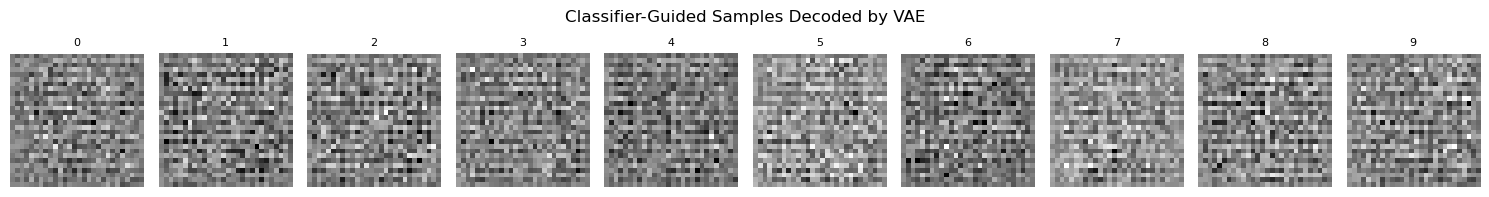

✅ Finished: Guided diffusion sampling + VAE decoding


In [97]:
# ===== Diffusion Configs =====
T = 25000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, dim=0)

@torch.no_grad()
def q_sample(z0, t):
    noise = torch.randn_like(z0)
    sqrt_ab = torch.sqrt(alphas_bar[t]).view(-1, 1)
    sqrt_mab = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)
    return sqrt_ab * z0 + sqrt_mab * noise

# ===== More Expressive Conditional Denoiser MLP =====
class ConditionalDenoiser(nn.Module):
    def __init__(self, latent_dim=20, n_classes=10):
        super().__init__()
        self.embed_class = nn.Embedding(n_classes, 64)
        self.embed_time = nn.Sequential(
            nn.Linear(1, 64), nn.GELU(),
            nn.Linear(64, 64)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 128, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, latent_dim)
        )

    def forward(self, zt, t, y):
        t_embed = self.embed_time(t.float().unsqueeze(1) / T)
        y_embed = self.embed_class(y)
        cond = torch.cat([t_embed, y_embed], dim=1)
        return self.net(torch.cat([zt, cond], dim=1))

# ===== Fast Analytic grad log p(y | z) for linear classifier =====
@torch.no_grad()
def grad_logp(y, z):
    logits = z_classifier(z)
    probs = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=probs.size(1)).float()
    diff = onehot - probs
    W = z_classifier.linear.weight
    return diff @ W

den_model = ConditionalDenoiser().to(z_all.device)
optimizer = torch.optim.Adam(den_model.parameters(), lr=.01*1e-3)

# ===== Diffusion Training Loop with Best Model Saving =====






dataset = TensorDataset(z_sampled, y_sampled)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

best_loss = float('inf')
best_state_dict = None

den_model.train()
for epoch in range(500):
    total_loss = 0
    for z0, y in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        z0, y = z0.to(z_all.device), y.to(z_all.device)
        t = torch.randint(0, T, (z0.size(0),), device=z0.device)
        zt = q_sample(z0, t)
        noise = (zt - torch.sqrt(alphas_bar[t].view(-1, 1)) * z0) / torch.sqrt(1 - alphas_bar[t].view(-1, 1))

        pred_noise = den_model(zt, t, y)
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_state_dict = den_model.state_dict()

# Save the best model
if best_state_dict is not None:
    torch.save(best_state_dict, "best_conditional_latent_denoiser.pth")
    print("✅ Best model saved as 'best_conditional_latent_denoiser.pth'")

# ===== Guided Sample Function =====
@torch.no_grad()
def sample_guided(y_label, guidance_scale=0., n=10):
    den_model.eval()
    zt = torch.randn(n, z_all.shape[1], device=z_all.device)
    y_tensor = torch.full((n,), y_label, dtype=torch.long, device=zt.device)

    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, dtype=torch.long, device=zt.device)
        eps_theta = den_model(zt, t_tensor, y_tensor)
        score = grad_logp(y_tensor, zt)
        guided_eps = eps_theta - guidance_scale * score

        alpha_t, beta_t = alphas[t], betas[t]
        zt = (1 / torch.sqrt(alpha_t)) * (zt - beta_t / torch.sqrt(1 - alphas_bar[t]) * guided_eps)
        if t > 0:
            zt += torch.randn_like(zt) * torch.sqrt(beta_t)

    return zt.detach()

# ===== Decode Diffusion-Guided Latents Using VAE Decoder =====
def decode_guided_samples(model, n_per_class=1):
    model.eval()
    fig, axs = plt.subplots(1, 10, figsize=(15, 2))

    for digit in range(10):
        z_sample = sample_guided(y_label=digit, n=n_per_class)
        with torch.no_grad():
            x_gen = model.decode(z_sample).cpu()

        for i in range(n_per_class):
            axs[digit].imshow(x_gen[i, 0], cmap="gray")
            axs[digit].axis("off")
            axs[digit].set_title(str(digit), fontsize=8)

    plt.suptitle("Classifier-Guided Samples Decoded by VAE")
    plt.tight_layout()
    plt.savefig("guided_diffusion_decoded.png", dpi=300)
    plt.show()

decode_guided_samples(vae_decoder, n_per_class=5)
print("✅ Finished: Guided diffusion sampling + VAE decoding")


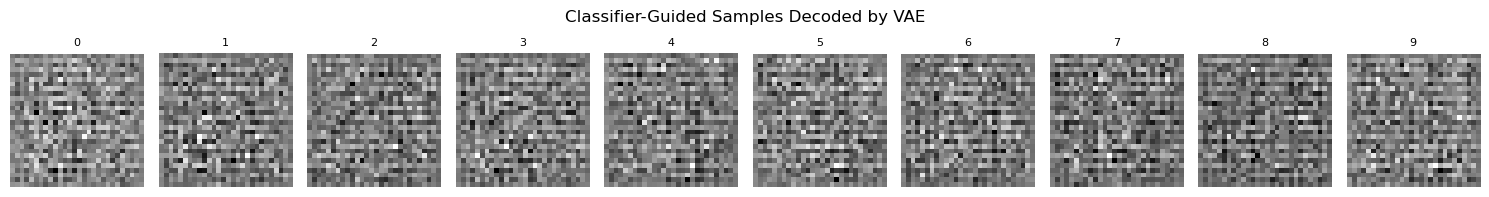

✅ Finished: Guided diffusion sampling + VAE decoding


In [78]:
torch.save(den_model.state_dict(), "conditional_latent_denoiser.pth")

# ===== Guided Sample Function =====
@torch.no_grad()
def sample_guided(y_label, guidance_scale=1.5, n=10):
    den_model.eval()
    zt = torch.randn(n, z_all.shape[1], device=z_all.device)
    y_tensor = torch.full((n,), y_label, dtype=torch.long, device=zt.device)

    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, dtype=torch.long, device=zt.device)
        eps_theta = den_model(zt, t_tensor, y_tensor)
        score = grad_logp(y_tensor, zt)
        guided_eps = eps_theta - guidance_scale * score

        alpha_t, beta_t = alphas[t], betas[t]
        zt = (1 / torch.sqrt(alpha_t)) * (zt - beta_t / torch.sqrt(1 - alphas_bar[t]) * guided_eps)
        if t > 0:
            zt += torch.randn_like(zt) * torch.sqrt(beta_t)

    return zt.detach()

# ===== Decode Diffusion-Guided Latents Using VAE Decoder =====
def decode_guided_samples(model, n_per_class=5):
    model.eval()
    fig, axs = plt.subplots(1, 10, figsize=(15, 2))

    for digit in range(10):
        z_sample = sample_guided(y_label=digit, n=n_per_class)
        with torch.no_grad():
            x_gen = model.decode(z_sample).cpu()

        for i in range(n_per_class):
            axs[digit].imshow(x_gen[i, 0], cmap="gray")
            axs[digit].axis("off")
            axs[digit].set_title(str(digit), fontsize=8)

    plt.suptitle("Classifier-Guided Samples Decoded by VAE")
    plt.tight_layout()
    plt.savefig("guided_diffusion_decoded.png", dpi=300)
    plt.show()

decode_guided_samples(vae_decoder, n_per_class=5)
print("✅ Finished: Guided diffusion sampling + VAE decoding")


In [ ]:
# === Train Conditional Diffusion Model on VAE Embeddings with Classifier-Based Guidance ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Load Latent Data from VAE =====
data = np.load("latent_embeddings.npz")
z_all = torch.tensor(data['z'], dtype=torch.float32)
y_all = torch.tensor(data['y'], dtype=torch.long)

# ===== Store mean/std but DO NOT normalize z_all for training =====
z_mean, z_std = z_all.mean(0, keepdim=True), z_all.std(0, keepdim=True)

# ===== Load Decoder from Trained VAE Model =====
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

vae_decoder = ConvVAE().to(z_all.device)
vae_decoder.load_state_dict(torch.load("vae_model_decoder.pth"))
vae_decoder.eval()

# ===== Train Separate Linear Classifier on Raw z_all =====
class ZClassifier(nn.Module):
    def __init__(self, dim_z=20, num_classes=10):
        super().__init__()
        self.linear = nn.Linear(dim_z, num_classes)

    def forward(self, z):
        return self.linear(z)

z_classifier = ZClassifier().to(z_all.device)
clf_optimizer = torch.optim.Adam(z_classifier.parameters(), lr=1e-3)
clf_criterion = nn.CrossEntropyLoss()
clf_loader = DataLoader(TensorDataset(z_all, y_all), batch_size=256, shuffle=True)

for epoch in range(10):
    total_loss, correct, total = 0, 0, 0
    z_classifier.train()
    for z, y in clf_loader:
        z, y = z.to(z_all.device), y.to(z_all.device)
        logits = z_classifier(z)
        loss = clf_criterion(logits, y)
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()
        total_loss += loss.item()
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    acc = correct / total
    print(f"Z Classifier Epoch {epoch+1}: Loss={total_loss/len(clf_loader):.4f}, Acc={acc:.4f}")

# ===== Beta Schedule Options =====
def linear_beta_schedule(T, beta_min=1e-4, beta_max=0.02):
    return torch.linspace(beta_min, beta_max, T)

def optimal_beta_schedule_sigma_ramp(T, sigma_0=0.1, sigma_1=0.9):
    t = torch.linspace(0, 1, T)
    delta_sigma = sigma_1 - sigma_0
    sigma_t = sigma_0 + t * delta_sigma
    gamma_t = sigma_t ** 2
    eta_t = delta_sigma / (sigma_t * T)
    return gamma_t + eta_t / T

# ===== Diffusion Configs =====
T = 100
schedules = {
    'linear': linear_beta_schedule(T),
    'cd_opt': optimal_beta_schedule_sigma_ramp(T)
}

best_loss = float('inf')
best_state = None
best_schedule = None

# ===== Fast Analytic grad log p(y | z) for linear classifier =====
@torch.no_grad()
def grad_logp(y, z):
    logits = z_classifier(z)
    probs = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=probs.size(1)).float()
    diff = onehot - probs
    W = z_classifier.linear.weight
    return diff @ W

for schedule_name, betas in schedules.items():
    print(f"Training with schedule: {schedule_name}")
    alphas = 1. - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    def q_sample(z0, t):
        noise = torch.randn_like(z0)
        sqrt_ab = torch.sqrt(alphas_bar[t]).view(-1, 1)
        sqrt_mab = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)
        return sqrt_ab * z0 + sqrt_mab * noise

    class ConditionalDenoiser(nn.Module):
        def __init__(self, latent_dim=20, n_classes=10):
            super().__init__()
            self.embed_class = nn.Embedding(n_classes, 64)
            self.embed_time = nn.Sequential(
                nn.Linear(1, 64), nn.GELU(),
                nn.Linear(64, 64)
            )
            self.net = nn.Sequential(
                nn.Linear(latent_dim + 128, 512), nn.GELU(),
                nn.Linear(512, 512), nn.GELU(),
                nn.Linear(512, 512), nn.GELU(),
                nn.Linear(512, latent_dim)
            )

        def forward(self, zt, t, y):
            t_embed = self.embed_time(t.float().unsqueeze(1) / T)
            y_embed = self.embed_class(y)
            cond = torch.cat([t_embed, y_embed], dim=1)
            return self.net(torch.cat([zt, cond], dim=1))

    den_model = ConditionalDenoiser().to(z_all.device)
    optimizer = torch.optim.Adam(den_model.parameters(), lr=1e-3)
    dataloader = DataLoader(TensorDataset(z_all, y_all), batch_size=256, shuffle=True)

    den_model.train()
    for epoch in range(50):
        total_loss = 0
        for z0, y in tqdm(dataloader, desc=f"{schedule_name} Epoch {epoch+1}"):
            z0, y = z0.to(z_all.device), y.to(z_all.device)
            t = torch.randint(0, T, (z0.size(0),), device=z0.device)
            zt = q_sample(z0, t)
            noise = (zt - torch.sqrt(alphas_bar[t].view(-1, 1)) * z0) / torch.sqrt(1 - alphas_bar[t].view(-1, 1))

            pred_noise = den_model(zt, t, y)
            loss = F.mse_loss(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"{schedule_name} Epoch {epoch+1}: Loss = {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = den_model.state_dict()
            best_schedule = schedule_name

# Save best model
if best_state is not None:
    torch.save(best_state, "best_conditional_latent_denoiser.pth")
    print(f"✅ Best model saved from schedule: {best_schedule}")
